In [270]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt

In [2]:
# Reproducibility
seed = 9 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [3]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [4]:
### RECEIVE 10,000 PIECES OF DATA ###

N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
# X_scale, X_test, Y_scale, Y_test = train_test_split(X_scale, Y_scale, test_size=0.15)

In [5]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
    hp_regularizer = hp.Choice('regularizer_penalty', values=[1e-4, 1e-5, 1e-6])
    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=56, max_value=200, step=4), kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
#     model.add(keras.layers.Dense(hp.Int('hidden_units', min_value=10, max_value=320, step=1), kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
#         model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1)))
#     SHOULD DROPOUT BE INCLUDED??
#     model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [6]:
### CREATE HYPERBAND TUNER ###

# The maximum number of epochs to train one model. It is recommended to 
# set this to a value slightly higher than the expected time 
# to convergence for your largest Model, and to use early stopping 
# during training
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_mean_squared_error', 'min'),
                     max_epochs=100,
                     factor=3,
                     directory='/Users/jackkelly/Desktop/Building_Model/',
                     project_name='intro_to_kt_layers',
                     overwrite=True,
                     seed=8)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5)

In [7]:
### SEARCHING FOR THE ANN LAYOUT THAT ACCOMPLISHES THE HYPERPARAMTER GOALS ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.2, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1278 - mean_squared_error: 0.1126 - mean_absolute_error: 0.3018 - val_loss: 0.0649 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1874
Epoch 2/2
8000/8000 - 1s - loss: 0.0501 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1386 - val_loss: 0.0438 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.1089


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0282 - mean_squared_error: 0.0242 - mean_absolute_error: 0.0977 - val_loss: 0.0067 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0332
Epoch 2/2
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0310 - val_loss: 0.0072 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0342


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2092 - mean_squared_error: 0.2075 - mean_absolute_error: 0.4273 - val_loss: 0.1903 - val_mean_squared_error: 0.1886 - val_mean_absolute_error: 0.4061
Epoch 2/2
8000/8000 - 1s - loss: 0.1740 - mean_squared_error: 0.1723 - mean_absolute_error: 0.3864 - val_loss: 0.1591 - val_mean_squared_error: 0.1573 - val_mean_absolute_error: 0.3671


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0935 - mean_squared_error: 0.0933 - mean_absolute_error: 0.2681 - val_loss: 0.0249 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1385
Epoch 2/2
8000/8000 - 1s - loss: 0.0116 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0924 - val_loss: 0.0056 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0642


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0172 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0542 - val_loss: 0.0061 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0249
Epoch 2/2
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0298 - val_loss: 0.0078 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0342


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2186 - mean_squared_error: 0.2185 - mean_absolute_error: 0.4386 - val_loss: 0.2028 - val_mean_squared_error: 0.2027 - val_mean_absolute_error: 0.4210
Epoch 2/2
8000/8000 - 1s - loss: 0.1924 - mean_squared_error: 0.1923 - mean_absolute_error: 0.4088 - val_loss: 0.1844 - val_mean_squared_error: 0.1843 - val_mean_absolute_error: 0.3977


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2008 - mean_squared_error: 0.2007 - mean_absolute_error: 0.4219 - val_loss: 0.1842 - val_mean_squared_error: 0.1840 - val_mean_absolute_error: 0.4008
Epoch 2/2
8000/8000 - 1s - loss: 0.1698 - mean_squared_error: 0.1697 - mean_absolute_error: 0.3854 - val_loss: 0.1568 - val_mean_squared_error: 0.1567 - val_mean_absolute_error: 0.3685


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0205 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0734 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0298
Epoch 2/2
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0298 - val_loss: 0.0068 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0305


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2044 - mean_squared_error: 0.2025 - mean_absolute_error: 0.4200 - val_loss: 0.1855 - val_mean_squared_error: 0.1836 - val_mean_absolute_error: 0.3991
Epoch 2/2
8000/8000 - 1s - loss: 0.1671 - mean_squared_error: 0.1652 - mean_absolute_error: 0.3774 - val_loss: 0.1502 - val_mean_squared_error: 0.1482 - val_mean_absolute_error: 0.3551


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2004 - mean_squared_error: 0.1991 - mean_absolute_error: 0.4225 - val_loss: 0.1820 - val_mean_squared_error: 0.1807 - val_mean_absolute_error: 0.3985
Epoch 2/2
8000/8000 - 1s - loss: 0.1659 - mean_squared_error: 0.1645 - mean_absolute_error: 0.3803 - val_loss: 0.1507 - val_mean_squared_error: 0.1493 - val_mean_absolute_error: 0.3609


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2226 - mean_squared_error: 0.2050 - mean_absolute_error: 0.4261 - val_loss: 0.2049 - val_mean_squared_error: 0.1874 - val_mean_absolute_error: 0.4041
Epoch 2/2
8000/8000 - 1s - loss: 0.1903 - mean_squared_error: 0.1727 - mean_absolute_error: 0.3873 - val_loss: 0.1756 - val_mean_squared_error: 0.1579 - val_mean_absolute_error: 0.3680


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0978 - mean_squared_error: 0.0959 - mean_absolute_error: 0.2732 - val_loss: 0.0292 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1440
Epoch 2/2
8000/8000 - 1s - loss: 0.0158 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0971 - val_loss: 0.0099 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0686


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2123 - mean_squared_error: 0.2112 - mean_absolute_error: 0.4278 - val_loss: 0.2005 - val_mean_squared_error: 0.1995 - val_mean_absolute_error: 0.4144
Epoch 2/2
8000/8000 - 1s - loss: 0.1905 - mean_squared_error: 0.1894 - mean_absolute_error: 0.4040 - val_loss: 0.1830 - val_mean_squared_error: 0.1819 - val_mean_absolute_error: 0.3945


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1527 - mean_squared_error: 0.1415 - mean_absolute_error: 0.3441 - val_loss: 0.0949 - val_mean_squared_error: 0.0806 - val_mean_absolute_error: 0.2535
Epoch 2/2
8000/8000 - 1s - loss: 0.0715 - mean_squared_error: 0.0529 - mean_absolute_error: 0.2002 - val_loss: 0.0560 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1588


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0194 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0695 - val_loss: 0.0067 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0299
Epoch 2/2
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0299 - val_loss: 0.0070 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0323


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0797 - mean_squared_error: 0.0768 - mean_absolute_error: 0.2263 - val_loss: 0.0184 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0974
Epoch 2/2
8000/8000 - 1s - loss: 0.0105 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0629 - val_loss: 0.0074 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0431


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1312 - mean_squared_error: 0.1114 - mean_absolute_error: 0.2895 - val_loss: 0.0739 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1840
Epoch 2/2
8000/8000 - 1s - loss: 0.0556 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1306 - val_loss: 0.0462 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0968


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1327 - mean_squared_error: 0.1185 - mean_absolute_error: 0.3110 - val_loss: 0.0731 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.2057
Epoch 2/2
8000/8000 - 1s - loss: 0.0545 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1542 - val_loss: 0.0454 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1191


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1283 - mean_squared_error: 0.1282 - mean_absolute_error: 0.3245 - val_loss: 0.0625 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.2193
Epoch 2/2
8000/8000 - 1s - loss: 0.0343 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1575 - val_loss: 0.0166 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1108


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2167 - mean_squared_error: 0.1939 - mean_absolute_error: 0.4137 - val_loss: 0.1917 - val_mean_squared_error: 0.1690 - val_mean_absolute_error: 0.3849
Epoch 2/2
8000/8000 - 1s - loss: 0.1688 - mean_squared_error: 0.1457 - mean_absolute_error: 0.3553 - val_loss: 0.1475 - val_mean_squared_error: 0.1239 - val_mean_absolute_error: 0.3246


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0157 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0596 - val_loss: 0.0016 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0199
Epoch 2/2
8000/8000 - 1s - loss: 0.0020 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0222 - val_loss: 0.0031 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0274


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0187 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0599 - val_loss: 0.0061 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0258
Epoch 2/2
8000/8000 - 1s - loss: 0.0063 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0279 - val_loss: 0.0067 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0300


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1933 - mean_squared_error: 0.1909 - mean_absolute_error: 0.4105 - val_loss: 0.1656 - val_mean_squared_error: 0.1631 - val_mean_absolute_error: 0.3791
Epoch 2/2
8000/8000 - 1s - loss: 0.1392 - mean_squared_error: 0.1366 - mean_absolute_error: 0.3440 - val_loss: 0.1147 - val_mean_squared_error: 0.1121 - val_mean_absolute_error: 0.3085


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0175 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0722 - val_loss: 0.0012 - val_mean_squared_error: 5.7091e-04 - val_mean_absolute_error: 0.0190
Epoch 2/2
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 5.0413e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0012 - val_mean_squared_error: 4.4134e-04 - val_mean_absolute_error: 0.0157


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0538 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1036 - val_loss: 0.0392 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0715
Epoch 2/2
8000/8000 - 1s - loss: 0.0396 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0726 - val_loss: 0.0401 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0739


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1211 - mean_squared_error: 0.1210 - mean_absolute_error: 0.3131 - val_loss: 0.0493 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1958
Epoch 2/2
8000/8000 - 1s - loss: 0.0246 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1342 - val_loss: 0.0109 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0913


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0225 - mean_squared_error: 0.0221 - mean_absolute_error: 0.0802 - val_loss: 0.0012 - val_mean_squared_error: 7.1392e-04 - val_mean_absolute_error: 0.0187
Epoch 2/2
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 6.9703e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0019 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0214


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0513 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0946 - val_loss: 0.0395 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0710
Epoch 2/2
8000/8000 - 1s - loss: 0.0401 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0731 - val_loss: 0.0411 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0758


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1093 - mean_squared_error: 0.1076 - mean_absolute_error: 0.2926 - val_loss: 0.0391 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1696
Epoch 2/2
8000/8000 - 1s - loss: 0.0206 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1149 - val_loss: 0.0116 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0799


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0717 - mean_squared_error: 0.0685 - mean_absolute_error: 0.2095 - val_loss: 0.0131 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0796
Epoch 2/2
8000/8000 - 1s - loss: 0.0086 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0525 - val_loss: 0.0069 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0375


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2055 - mean_squared_error: 0.2054 - mean_absolute_error: 0.4265 - val_loss: 0.1890 - val_mean_squared_error: 0.1889 - val_mean_absolute_error: 0.4061
Epoch 2/2
8000/8000 - 1s - loss: 0.1751 - mean_squared_error: 0.1750 - mean_absolute_error: 0.3910 - val_loss: 0.1625 - val_mean_squared_error: 0.1624 - val_mean_absolute_error: 0.3752


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2218 - mean_squared_error: 0.2053 - mean_absolute_error: 0.4236 - val_loss: 0.2046 - val_mean_squared_error: 0.1882 - val_mean_absolute_error: 0.4046
Epoch 2/2
8000/8000 - 1s - loss: 0.1901 - mean_squared_error: 0.1737 - mean_absolute_error: 0.3876 - val_loss: 0.1770 - val_mean_squared_error: 0.1605 - val_mean_absolute_error: 0.3701


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2182 - mean_squared_error: 0.2073 - mean_absolute_error: 0.4260 - val_loss: 0.2040 - val_mean_squared_error: 0.1932 - val_mean_absolute_error: 0.4099
Epoch 2/2
8000/8000 - 1s - loss: 0.1935 - mean_squared_error: 0.1826 - mean_absolute_error: 0.3987 - val_loss: 0.1845 - val_mean_squared_error: 0.1736 - val_mean_absolute_error: 0.3871


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0672 - mean_squared_error: 0.0638 - mean_absolute_error: 0.1996 - val_loss: 0.0116 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0717
Epoch 2/2
8000/8000 - 1s - loss: 0.0082 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0489 - val_loss: 0.0069 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0359


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0186 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0668 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0297
Epoch 2/2
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0072 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0340


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0513 - mean_squared_error: 0.0187 - mean_absolute_error: 0.0963 - val_loss: 0.0394 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0712
Epoch 2/2
8000/8000 - 1s - loss: 0.0400 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0730 - val_loss: 0.0409 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0763


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2220 - mean_squared_error: 0.2105 - mean_absolute_error: 0.4334 - val_loss: 0.2066 - val_mean_squared_error: 0.1952 - val_mean_absolute_error: 0.4135
Epoch 2/2
8000/8000 - 1s - loss: 0.1951 - mean_squared_error: 0.1837 - mean_absolute_error: 0.4008 - val_loss: 0.1843 - val_mean_squared_error: 0.1728 - val_mean_absolute_error: 0.3870


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2149 - mean_squared_error: 0.1893 - mean_absolute_error: 0.4076 - val_loss: 0.1888 - val_mean_squared_error: 0.1632 - val_mean_absolute_error: 0.3789
Epoch 2/2
8000/8000 - 1s - loss: 0.1628 - mean_squared_error: 0.1369 - mean_absolute_error: 0.3445 - val_loss: 0.1400 - val_mean_squared_error: 0.1135 - val_mean_absolute_error: 0.3102


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0147 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0566 - val_loss: 0.0021 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0230
Epoch 2/2
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0248 - val_loss: 0.0034 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0277


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0518 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1144 - val_loss: 0.0412 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0902
Epoch 2/2
8000/8000 - 1s - loss: 0.0416 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0907 - val_loss: 0.0422 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0927


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1147 - mean_squared_error: 0.1132 - mean_absolute_error: 0.3014 - val_loss: 0.0454 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1828
Epoch 2/2
8000/8000 - 1s - loss: 0.0240 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1253 - val_loss: 0.0130 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0868


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0171 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0552 - val_loss: 0.0061 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0253
Epoch 2/2
8000/8000 - 1s - loss: 0.0065 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0291 - val_loss: 0.0078 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0348


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0905 - mean_squared_error: 0.0548 - mean_absolute_error: 0.1848 - val_loss: 0.0474 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0802
Epoch 2/2
8000/8000 - 1s - loss: 0.0438 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0731 - val_loss: 0.0413 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0707


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1003 - mean_squared_error: 0.1001 - mean_absolute_error: 0.2798 - val_loss: 0.0294 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1511
Epoch 2/2
8000/8000 - 1s - loss: 0.0137 - mean_squared_error: 0.0134 - mean_absolute_error: 0.1007 - val_loss: 0.0064 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0692


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2077 - mean_squared_error: 0.2076 - mean_absolute_error: 0.4296 - val_loss: 0.1914 - val_mean_squared_error: 0.1913 - val_mean_absolute_error: 0.4082
Epoch 2/2
8000/8000 - 1s - loss: 0.1793 - mean_squared_error: 0.1792 - mean_absolute_error: 0.3952 - val_loss: 0.1684 - val_mean_squared_error: 0.1683 - val_mean_absolute_error: 0.3811


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1957 - mean_squared_error: 0.1955 - mean_absolute_error: 0.4152 - val_loss: 0.1733 - val_mean_squared_error: 0.1731 - val_mean_absolute_error: 0.3877
Epoch 2/2
8000/8000 - 1s - loss: 0.1522 - mean_squared_error: 0.1519 - mean_absolute_error: 0.3619 - val_loss: 0.1318 - val_mean_squared_error: 0.1315 - val_mean_absolute_error: 0.3336


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0877 - mean_squared_error: 0.0850 - mean_absolute_error: 0.2410 - val_loss: 0.0225 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1118
Epoch 2/2
8000/8000 - 1s - loss: 0.0116 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0692 - val_loss: 0.0077 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0465


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1914 - mean_squared_error: 0.1912 - mean_absolute_error: 0.4101 - val_loss: 0.1635 - val_mean_squared_error: 0.1632 - val_mean_absolute_error: 0.3791
Epoch 2/2
8000/8000 - 1s - loss: 0.1362 - mean_squared_error: 0.1359 - mean_absolute_error: 0.3431 - val_loss: 0.1108 - val_mean_squared_error: 0.1105 - val_mean_absolute_error: 0.3062


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1098 - mean_squared_error: 0.0833 - mean_absolute_error: 0.2416 - val_loss: 0.0519 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1178
Epoch 2/2
8000/8000 - 1s - loss: 0.0446 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0864 - val_loss: 0.0416 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0729


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2012 - mean_squared_error: 0.1999 - mean_absolute_error: 0.4205 - val_loss: 0.1846 - val_mean_squared_error: 0.1833 - val_mean_absolute_error: 0.4007
Epoch 2/2
8000/8000 - 1s - loss: 0.1693 - mean_squared_error: 0.1680 - mean_absolute_error: 0.3838 - val_loss: 0.1552 - val_mean_squared_error: 0.1538 - val_mean_absolute_error: 0.3658


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2240 - mean_squared_error: 0.2126 - mean_absolute_error: 0.4356 - val_loss: 0.2081 - val_mean_squared_error: 0.1968 - val_mean_absolute_error: 0.4140
Epoch 2/2
8000/8000 - 1s - loss: 0.1966 - mean_squared_error: 0.1853 - mean_absolute_error: 0.4016 - val_loss: 0.1868 - val_mean_squared_error: 0.1755 - val_mean_absolute_error: 0.3891


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2225 - mean_squared_error: 0.2110 - mean_absolute_error: 0.4327 - val_loss: 0.2075 - val_mean_squared_error: 0.1960 - val_mean_absolute_error: 0.4133
Epoch 2/2
8000/8000 - 1s - loss: 0.1962 - mean_squared_error: 0.1848 - mean_absolute_error: 0.4011 - val_loss: 0.1861 - val_mean_squared_error: 0.1746 - val_mean_absolute_error: 0.3883


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2075 - mean_squared_error: 0.2057 - mean_absolute_error: 0.4253 - val_loss: 0.1879 - val_mean_squared_error: 0.1861 - val_mean_absolute_error: 0.4025
Epoch 2/2
8000/8000 - 1s - loss: 0.1718 - mean_squared_error: 0.1700 - mean_absolute_error: 0.3834 - val_loss: 0.1562 - val_mean_squared_error: 0.1544 - val_mean_absolute_error: 0.3622


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0512 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1125 - val_loss: 0.0413 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0899
Epoch 2/2
8000/8000 - 1s - loss: 0.0417 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0908 - val_loss: 0.0422 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0922


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1167 - mean_squared_error: 0.0997 - mean_absolute_error: 0.2811 - val_loss: 0.0569 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1637
Epoch 2/2
8000/8000 - 1s - loss: 0.0467 - mean_squared_error: 0.0189 - mean_absolute_error: 0.1231 - val_loss: 0.0428 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.1003


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2083 - mean_squared_error: 0.2071 - mean_absolute_error: 0.4280 - val_loss: 0.1916 - val_mean_squared_error: 0.1903 - val_mean_absolute_error: 0.4078
Epoch 2/2
8000/8000 - 1s - loss: 0.1775 - mean_squared_error: 0.1762 - mean_absolute_error: 0.3927 - val_loss: 0.1641 - val_mean_squared_error: 0.1627 - val_mean_absolute_error: 0.3758


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1092 - mean_squared_error: 0.1091 - mean_absolute_error: 0.2950 - val_loss: 0.0388 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1727
Epoch 2/2
8000/8000 - 1s - loss: 0.0187 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1173 - val_loss: 0.0084 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0801


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0750 - mean_squared_error: 0.0747 - mean_absolute_error: 0.2216 - val_loss: 0.0124 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0902
Epoch 2/2
8000/8000 - 1s - loss: 0.0053 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0566 - val_loss: 0.0027 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0378


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0218 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0775 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0301
Epoch 2/2
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0299 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0298


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0135 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0593 - val_loss: 0.0011 - val_mean_squared_error: 4.6729e-04 - val_mean_absolute_error: 0.0168
Epoch 2/2
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 5.3867e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0011 - val_mean_squared_error: 3.8552e-04 - val_mean_absolute_error: 0.0141


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0528 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1172 - val_loss: 0.0411 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0903
Epoch 2/2
8000/8000 - 1s - loss: 0.0415 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0906 - val_loss: 0.0419 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0926


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1925 - mean_squared_error: 0.1923 - mean_absolute_error: 0.4120 - val_loss: 0.1693 - val_mean_squared_error: 0.1691 - val_mean_absolute_error: 0.3844
Epoch 2/2
8000/8000 - 1s - loss: 0.1454 - mean_squared_error: 0.1452 - mean_absolute_error: 0.3542 - val_loss: 0.1231 - val_mean_squared_error: 0.1228 - val_mean_absolute_error: 0.3226


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2050 - mean_squared_error: 0.2038 - mean_absolute_error: 0.4248 - val_loss: 0.1904 - val_mean_squared_error: 0.1892 - val_mean_absolute_error: 0.4062
Epoch 2/2
8000/8000 - 1s - loss: 0.1773 - mean_squared_error: 0.1760 - mean_absolute_error: 0.3917 - val_loss: 0.1656 - val_mean_squared_error: 0.1644 - val_mean_absolute_error: 0.3772


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2008 - mean_squared_error: 0.1995 - mean_absolute_error: 0.4211 - val_loss: 0.1836 - val_mean_squared_error: 0.1823 - val_mean_absolute_error: 0.4001
Epoch 2/2
8000/8000 - 1s - loss: 0.1680 - mean_squared_error: 0.1666 - mean_absolute_error: 0.3828 - val_loss: 0.1534 - val_mean_squared_error: 0.1520 - val_mean_absolute_error: 0.3642


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2016 - mean_squared_error: 0.2014 - mean_absolute_error: 0.4243 - val_loss: 0.1835 - val_mean_squared_error: 0.1834 - val_mean_absolute_error: 0.4015
Epoch 2/2
8000/8000 - 1s - loss: 0.1677 - mean_squared_error: 0.1676 - mean_absolute_error: 0.3839 - val_loss: 0.1529 - val_mean_squared_error: 0.1528 - val_mean_absolute_error: 0.3652


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1920 - mean_squared_error: 0.1918 - mean_absolute_error: 0.4108 - val_loss: 0.1660 - val_mean_squared_error: 0.1658 - val_mean_absolute_error: 0.3819
Epoch 2/2
8000/8000 - 1s - loss: 0.1409 - mean_squared_error: 0.1406 - mean_absolute_error: 0.3490 - val_loss: 0.1163 - val_mean_squared_error: 0.1160 - val_mean_absolute_error: 0.3143


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0575 - mean_squared_error: 0.0299 - mean_absolute_error: 0.1316 - val_loss: 0.0410 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0908
Epoch 2/2
8000/8000 - 1s - loss: 0.0411 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0903 - val_loss: 0.0416 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0921


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0204 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0657 - val_loss: 0.0058 - val_mean_squared_error: 9.4136e-04 - val_mean_absolute_error: 0.0237
Epoch 2/2
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0248 - val_loss: 0.0061 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0276


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0801 - mean_squared_error: 0.0771 - mean_absolute_error: 0.2269 - val_loss: 0.0169 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0945
Epoch 2/2
8000/8000 - 1s - loss: 0.0099 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0607 - val_loss: 0.0073 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0422


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0176 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0570 - val_loss: 0.0062 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0264
Epoch 2/2
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0298 - val_loss: 0.0071 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0313


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0544 - mean_squared_error: 0.0234 - mean_absolute_error: 0.1061 - val_loss: 0.0391 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0710
Epoch 2/2
8000/8000 - 1s - loss: 0.0395 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0724 - val_loss: 0.0399 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0738


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0506 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0909 - val_loss: 0.0398 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0711
Epoch 2/2
8000/8000 - 1s - loss: 0.0406 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0737 - val_loss: 0.0418 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0755


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1440 - mean_squared_error: 0.1439 - mean_absolute_error: 0.3458 - val_loss: 0.0836 - val_mean_squared_error: 0.0834 - val_mean_absolute_error: 0.2558
Epoch 2/2
8000/8000 - 1s - loss: 0.0534 - mean_squared_error: 0.0532 - mean_absolute_error: 0.1963 - val_loss: 0.0318 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1496


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0595 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1369 - val_loss: 0.0410 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0909
Epoch 2/2
8000/8000 - 1s - loss: 0.0411 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0903 - val_loss: 0.0414 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0916


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0562 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1103 - val_loss: 0.0390 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0711
Epoch 2/2
8000/8000 - 1s - loss: 0.0394 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0723 - val_loss: 0.0396 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0728


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2258 - mean_squared_error: 0.2159 - mean_absolute_error: 0.4373 - val_loss: 0.2121 - val_mean_squared_error: 0.2023 - val_mean_absolute_error: 0.4213
Epoch 2/2
8000/8000 - 1s - loss: 0.2020 - mean_squared_error: 0.1923 - mean_absolute_error: 0.4090 - val_loss: 0.1946 - val_mean_squared_error: 0.1849 - val_mean_absolute_error: 0.3987


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0983 - mean_squared_error: 0.0675 - mean_absolute_error: 0.2116 - val_loss: 0.0482 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0947
Epoch 2/2
8000/8000 - 1s - loss: 0.0439 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0776 - val_loss: 0.0417 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0715


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1067 - mean_squared_error: 0.1065 - mean_absolute_error: 0.2905 - val_loss: 0.0361 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1666
Epoch 2/2
8000/8000 - 1s - loss: 0.0171 - mean_squared_error: 0.0168 - mean_absolute_error: 0.1120 - val_loss: 0.0077 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0765


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1408 - mean_squared_error: 0.1396 - mean_absolute_error: 0.3407 - val_loss: 0.0758 - val_mean_squared_error: 0.0742 - val_mean_absolute_error: 0.2419
Epoch 2/2
8000/8000 - 1s - loss: 0.0468 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1808 - val_loss: 0.0269 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1332


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0197 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0701 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0298
Epoch 2/2
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0300 - val_loss: 0.0072 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0337


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2150 - mean_squared_error: 0.2025 - mean_absolute_error: 0.4236 - val_loss: 0.1993 - val_mean_squared_error: 0.1868 - val_mean_absolute_error: 0.4036
Epoch 2/2
8000/8000 - 1s - loss: 0.1854 - mean_squared_error: 0.1728 - mean_absolute_error: 0.3887 - val_loss: 0.1727 - val_mean_squared_error: 0.1600 - val_mean_absolute_error: 0.3728


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2263 - mean_squared_error: 0.2149 - mean_absolute_error: 0.4382 - val_loss: 0.2100 - val_mean_squared_error: 0.1986 - val_mean_absolute_error: 0.4176
Epoch 2/2
8000/8000 - 1s - loss: 0.1983 - mean_squared_error: 0.1870 - mean_absolute_error: 0.4041 - val_loss: 0.1891 - val_mean_squared_error: 0.1778 - val_mean_absolute_error: 0.3920


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0942 - mean_squared_error: 0.0923 - mean_absolute_error: 0.2669 - val_loss: 0.0271 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1385
Epoch 2/2
8000/8000 - 1s - loss: 0.0149 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0937 - val_loss: 0.0096 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0669


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1022 - mean_squared_error: 0.0729 - mean_absolute_error: 0.2225 - val_loss: 0.0495 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.1032
Epoch 2/2
8000/8000 - 1s - loss: 0.0444 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0808 - val_loss: 0.0420 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0721


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1339 - mean_squared_error: 0.1326 - mean_absolute_error: 0.3313 - val_loss: 0.0684 - val_mean_squared_error: 0.0666 - val_mean_absolute_error: 0.2290
Epoch 2/2
8000/8000 - 1s - loss: 0.0404 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1675 - val_loss: 0.0222 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1207


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0174 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0565 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0250
Epoch 2/2
8000/8000 - 1s - loss: 0.0063 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0279 - val_loss: 0.0067 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0292


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0527 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1174 - val_loss: 0.0411 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0903
Epoch 2/2
8000/8000 - 1s - loss: 0.0414 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0905 - val_loss: 0.0419 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0927


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0552 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1244 - val_loss: 0.0410 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0904
Epoch 2/2
8000/8000 - 1s - loss: 0.0413 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0904 - val_loss: 0.0419 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0930


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0809 - mean_squared_error: 0.0807 - mean_absolute_error: 0.2339 - val_loss: 0.0164 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1031
Epoch 2/2
8000/8000 - 1s - loss: 0.0069 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0642 - val_loss: 0.0032 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0425


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0547 - mean_squared_error: 0.0260 - mean_absolute_error: 0.1233 - val_loss: 0.0410 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0902
Epoch 2/2
8000/8000 - 1s - loss: 0.0413 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0904 - val_loss: 0.0419 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0931


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0120 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0494 - val_loss: 0.0037 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0297
Epoch 2/2
8000/8000 - 1s - loss: 0.0094 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0424 - val_loss: 0.0436 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.0864


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0190 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0603 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0246
Epoch 2/2
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0265 - val_loss: 0.0066 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0304


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0524 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1000 - val_loss: 0.0393 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0710
Epoch 2/2
8000/8000 - 1s - loss: 0.0397 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0727 - val_loss: 0.0403 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0742


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1087 - mean_squared_error: 0.0828 - mean_absolute_error: 0.2401 - val_loss: 0.0527 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1194
Epoch 2/2
8000/8000 - 1s - loss: 0.0450 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0881 - val_loss: 0.0417 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0738


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1247 - mean_squared_error: 0.1091 - mean_absolute_error: 0.2970 - val_loss: 0.0642 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1846
Epoch 2/2
8000/8000 - 1s - loss: 0.0501 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1378 - val_loss: 0.0437 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.1080


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1941 - mean_squared_error: 0.1915 - mean_absolute_error: 0.4115 - val_loss: 0.1661 - val_mean_squared_error: 0.1634 - val_mean_absolute_error: 0.3785
Epoch 2/2
8000/8000 - 1s - loss: 0.1389 - mean_squared_error: 0.1362 - mean_absolute_error: 0.3430 - val_loss: 0.1132 - val_mean_squared_error: 0.1104 - val_mean_absolute_error: 0.3063


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0519 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1145 - val_loss: 0.0412 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0901
Epoch 2/2
8000/8000 - 1s - loss: 0.0416 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0907 - val_loss: 0.0421 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0925


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0980 - mean_squared_error: 0.0978 - mean_absolute_error: 0.2761 - val_loss: 0.0288 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1489
Epoch 2/2
8000/8000 - 1s - loss: 0.0134 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0993 - val_loss: 0.0063 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0686


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0140 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0609 - val_loss: 0.0012 - val_mean_squared_error: 4.9036e-04 - val_mean_absolute_error: 0.0172
Epoch 4/4
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.4992e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0011 - val_mean_squared_error: 4.0850e-04 - val_mean_absolute_error: 0.0147


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0179 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0731 - val_loss: 0.0012 - val_mean_squared_error: 5.8808e-04 - val_mean_absolute_error: 0.0193
Epoch 4/4
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 4.9262e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0011 - val_mean_squared_error: 4.0154e-04 - val_mean_absolute_error: 0.0151


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0229 - mean_squared_error: 0.0225 - mean_absolute_error: 0.0813 - val_loss: 0.0013 - val_mean_squared_error: 7.5657e-04 - val_mean_absolute_error: 0.0190
Epoch 4/4
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 7.9200e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0016 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0200


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0204 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0654 - val_loss: 0.0059 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0245
Epoch 4/4
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0255 - val_loss: 0.0063 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0291


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0158 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0613 - val_loss: 0.0021 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0233
Epoch 4/4
8000/8000 - 1s - loss: 0.0022 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0236 - val_loss: 0.0029 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0263


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0178 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0571 - val_loss: 0.0061 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0254
Epoch 4/4
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0286 - val_loss: 0.0075 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0339


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0172 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0548 - val_loss: 0.0061 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0247
Epoch 4/4
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0284 - val_loss: 0.0073 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0325


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0175 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0565 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0244
Epoch 4/4
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0286 - val_loss: 0.0075 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0333


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0177 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0569 - val_loss: 0.0060 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0243
Epoch 4/4
8000/8000 - 1s - loss: 0.0063 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0281 - val_loss: 0.0064 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0280


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0186 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0598 - val_loss: 0.0059 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0244
Epoch 4/4
8000/8000 - 1s - loss: 0.0062 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0272 - val_loss: 0.0064 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0296


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0202 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0724 - val_loss: 0.0067 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0300
Epoch 4/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0298 - val_loss: 0.0069 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0312


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0212 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0758 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0300
Epoch 4/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0298 - val_loss: 0.0067 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0301


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0185 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0664 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0296
Epoch 4/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0301 - val_loss: 0.0071 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0335


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0193 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0693 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0298
Epoch 4/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0300 - val_loss: 0.0072 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0338


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0183 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0582 - val_loss: 0.0060 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0251
Epoch 4/4
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0283 - val_loss: 0.0071 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0322


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0193 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0692 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0297
Epoch 4/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0300 - val_loss: 0.0071 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0335


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0140 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0556 - val_loss: 0.0020 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0223
Epoch 4/4
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0246 - val_loss: 0.0033 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0272


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0288 - mean_squared_error: 0.0249 - mean_absolute_error: 0.0993 - val_loss: 0.0068 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0336
Epoch 4/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0311 - val_loss: 0.0072 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0342


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0687 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2026 - val_loss: 0.0120 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0739
Epoch 4/4
8000/8000 - 1s - loss: 0.0084 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0498 - val_loss: 0.0070 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0364


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0719 - mean_squared_error: 0.0687 - mean_absolute_error: 0.2092 - val_loss: 0.0135 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0803
Epoch 4/4
8000/8000 - 1s - loss: 0.0087 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0527 - val_loss: 0.0069 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0375


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0740 - mean_squared_error: 0.0737 - mean_absolute_error: 0.2198 - val_loss: 0.0115 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0875
Epoch 4/4
8000/8000 - 1s - loss: 0.0050 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0548 - val_loss: 0.0026 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0369


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0790 - mean_squared_error: 0.0760 - mean_absolute_error: 0.2249 - val_loss: 0.0168 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0940
Epoch 4/4
8000/8000 - 1s - loss: 0.0100 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0611 - val_loss: 0.0073 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0424


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0831 - mean_squared_error: 0.0828 - mean_absolute_error: 0.2378 - val_loss: 0.0166 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1051
Epoch 4/4
8000/8000 - 1s - loss: 0.0068 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0646 - val_loss: 0.0032 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0428


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0819 - mean_squared_error: 0.0791 - mean_absolute_error: 0.2307 - val_loss: 0.0199 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1030
Epoch 4/4
8000/8000 - 1s - loss: 0.0110 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0659 - val_loss: 0.0077 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0454


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0112 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0482 - val_loss: 0.0044 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0338
Epoch 4/4
8000/8000 - 1s - loss: 0.0210 - mean_squared_error: 0.0199 - mean_absolute_error: 0.0571 - val_loss: 0.0325 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.0680


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0831 - mean_squared_error: 0.0804 - mean_absolute_error: 0.2332 - val_loss: 0.0212 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1072
Epoch 4/4
8000/8000 - 1s - loss: 0.0115 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0681 - val_loss: 0.0077 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0462


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0942 - mean_squared_error: 0.0941 - mean_absolute_error: 0.2694 - val_loss: 0.0253 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1399
Epoch 4/4
8000/8000 - 1s - loss: 0.0117 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0931 - val_loss: 0.0057 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0647


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0962 - mean_squared_error: 0.0944 - mean_absolute_error: 0.2701 - val_loss: 0.0278 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1403
Epoch 4/4
8000/8000 - 1s - loss: 0.0151 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0947 - val_loss: 0.0096 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0673


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0999 - mean_squared_error: 0.0981 - mean_absolute_error: 0.2757 - val_loss: 0.0301 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1467
Epoch 4/4
8000/8000 - 1s - loss: 0.0161 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0985 - val_loss: 0.0100 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0695


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0995 - mean_squared_error: 0.0993 - mean_absolute_error: 0.2788 - val_loss: 0.0293 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1503
Epoch 4/4
8000/8000 - 1s - loss: 0.0137 - mean_squared_error: 0.0133 - mean_absolute_error: 0.1003 - val_loss: 0.0064 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0691


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 1s - loss: 0.0991 - mean_squared_error: 0.0989 - mean_absolute_error: 0.2784 - val_loss: 0.0294 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1509
Epoch 4/4
8000/8000 - 1s - loss: 0.0138 - mean_squared_error: 0.0135 - mean_absolute_error: 0.1009 - val_loss: 0.0065 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0696


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0919 - mean_squared_error: 0.0563 - mean_absolute_error: 0.1876 - val_loss: 0.0475 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0810
Epoch 4/4
8000/8000 - 1s - loss: 0.0438 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0733 - val_loss: 0.0414 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0707


Train on 8000 samples, validate on 2000 samples
Epoch 3/4
8000/8000 - 2s - loss: 0.0982 - mean_squared_error: 0.0673 - mean_absolute_error: 0.2117 - val_loss: 0.0484 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0950
Epoch 4/4
8000/8000 - 1s - loss: 0.0441 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0778 - val_loss: 0.0418 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0716


Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 1s - loss: 0.0169 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0706 - val_loss: 0.0012 - val_mean_squared_error: 5.8205e-04 - val_mean_absolute_error: 0.0191
Epoch 6/12
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 4.7676e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0010 - val_mean_squared_error: 3.0158e-04 - val_mean_absolute_error: 0.0132
Epoch 7/12
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 3.5184e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0013 - val_mean_squared_error: 5.2641e-04 - val_mean_absolute_error: 0.0155
Epoch 8/12
8000/8000 - 1s - loss: 0.0014 - mean_squared_error: 6.5071e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0011 - val_mean_squared_error: 3.6449e-04 - val_mean_absolute_error: 0.0136
Epoch 9/12
8000/8000 - 1s - loss: 0.0020 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0205 - val_loss: 0.0016 - val_mean_squared_error: 8.9595e-04 - val_mean_absolute_erro

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0137 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0602 - val_loss: 0.0012 - val_mean_squared_error: 5.8234e-04 - val_mean_absolute_error: 0.0183
Epoch 6/12
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.4539e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0014 - val_mean_squared_error: 6.3688e-04 - val_mean_absolute_error: 0.0172
Epoch 7/12
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 4.3577e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0015 - val_mean_squared_error: 7.5737e-04 - val_mean_absolute_error: 0.0175
Epoch 8/12
8000/8000 - 1s - loss: 0.0016 - mean_squared_error: 8.8676e-04 - mean_absolute_error: 0.0183 - val_loss: 0.0016 - val_mean_squared_error: 8.5522e-04 - val_mean_absolute_error: 0.0180
Epoch 9/12
8000/8000 - 1s - loss: 0.0021 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0213 - val_loss: 0.0033 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0233 - mean_squared_error: 0.0229 - mean_absolute_error: 0.0818 - val_loss: 0.0013 - val_mean_squared_error: 8.0688e-04 - val_mean_absolute_error: 0.0194
Epoch 6/12
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 8.0151e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0026 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0254
Epoch 7/12
8000/8000 - 1s - loss: 0.0018 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0209 - val_loss: 0.0016 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0192
Epoch 8/12
8000/8000 - 1s - loss: 0.0020 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0218 - val_loss: 0.0024 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0245
Epoch 9/12
8000/8000 - 1s - loss: 0.0030 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0270 - val_loss: 0.0039 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0313
Epoch 10/12
80

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0170 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0551 - val_loss: 0.0061 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0254
Epoch 6/12
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0285 - val_loss: 0.0072 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0322
Epoch 7/12
8000/8000 - 1s - loss: 0.0087 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0367 - val_loss: 0.0158 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0515
Epoch 8/12
8000/8000 - 1s - loss: 0.0367 - mean_squared_error: 0.0243 - mean_absolute_error: 0.0641 - val_loss: 0.0272 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0477
Epoch 9/12
8000/8000 - 1s - loss: 0.0224 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0442 - val_loss: 0.0182 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0425
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0206 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0662 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0250
Epoch 6/12
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0253 - val_loss: 0.0065 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0305
Epoch 7/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0265 - val_loss: 0.0064 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0288
Epoch 8/12
8000/8000 - 1s - loss: 0.0070 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0318 - val_loss: 0.0076 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0342
Epoch 9/12
8000/8000 - 1s - loss: 0.0086 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0365 - val_loss: 0.0102 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0410
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0174 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0558 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0244
Epoch 6/12
8000/8000 - 1s - loss: 0.0065 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0288 - val_loss: 0.0076 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0331
Epoch 7/12
8000/8000 - 1s - loss: 0.0094 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0379 - val_loss: 0.0180 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0523
Epoch 8/12
8000/8000 - 1s - loss: 0.0293 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0576 - val_loss: 0.0278 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0521
Epoch 9/12
8000/8000 - 1s - loss: 0.0198 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0438 - val_loss: 0.0163 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0423
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0199 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0631 - val_loss: 0.0059 - val_mean_squared_error: 9.4044e-04 - val_mean_absolute_error: 0.0235
Epoch 6/12
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0254 - val_loss: 0.0060 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0265
Epoch 7/12
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0271 - val_loss: 0.0068 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0302
Epoch 8/12
8000/8000 - 1s - loss: 0.0090 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0379 - val_loss: 0.0106 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0420
Epoch 9/12
8000/8000 - 1s - loss: 0.0194 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0519 - val_loss: 0.0317 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.0608
Epoch 10/12
8000/8

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0168 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0540 - val_loss: 0.0062 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0261
Epoch 6/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0299 - val_loss: 0.0081 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0350
Epoch 7/12
8000/8000 - 1s - loss: 0.0172 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0480 - val_loss: 0.0499 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.0802
Epoch 8/12
8000/8000 - 1s - loss: 0.0487 - mean_squared_error: 0.0307 - mean_absolute_error: 0.0683 - val_loss: 0.0296 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0459
Epoch 9/12
8000/8000 - 1s - loss: 0.0242 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0432 - val_loss: 0.0201 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0430
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0177 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0564 - val_loss: 0.0061 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0251
Epoch 6/12
8000/8000 - 1s - loss: 0.0062 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0274 - val_loss: 0.0063 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0280
Epoch 7/12
8000/8000 - 1s - loss: 0.0074 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0327 - val_loss: 0.0093 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0376
Epoch 8/12
8000/8000 - 1s - loss: 0.0397 - mean_squared_error: 0.0292 - mean_absolute_error: 0.0698 - val_loss: 0.0537 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.0735
Epoch 9/12
8000/8000 - 1s - loss: 0.0383 - mean_squared_error: 0.0192 - mean_absolute_error: 0.0551 - val_loss: 0.0259 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0440
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0182 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0584 - val_loss: 0.0061 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0257
Epoch 6/12
8000/8000 - 1s - loss: 0.0063 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0278 - val_loss: 0.0067 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0300
Epoch 7/12
8000/8000 - 1s - loss: 0.0072 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0319 - val_loss: 0.0093 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0383
Epoch 8/12
8000/8000 - 1s - loss: 0.0333 - mean_squared_error: 0.0233 - mean_absolute_error: 0.0634 - val_loss: 0.0294 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0508
Epoch 9/12
8000/8000 - 1s - loss: 0.0226 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0443 - val_loss: 0.0185 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0430
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 1s - loss: 0.0188 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0673 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0297
Epoch 6/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0301 - val_loss: 0.0072 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0341
Epoch 7/12
8000/8000 - 1s - loss: 0.0068 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0306 - val_loss: 0.0070 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0319
Epoch 8/12
8000/8000 - 1s - loss: 0.0069 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0311 - val_loss: 0.0071 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0316
Epoch 9/12
8000/8000 - 1s - loss: 0.0070 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0316 - val_loss: 0.0074 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0348
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 1s - loss: 0.0173 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0716 - val_loss: 0.0012 - val_mean_squared_error: 5.7780e-04 - val_mean_absolute_error: 0.0191
Epoch 14/34
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 4.7096e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0010 - val_mean_squared_error: 3.0816e-04 - val_mean_absolute_error: 0.0133
Epoch 15/34
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 3.6134e-04 - mean_absolute_error: 0.0139 - val_loss: 0.0013 - val_mean_squared_error: 5.2054e-04 - val_mean_absolute_error: 0.0155
Epoch 16/34
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.7964e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0012 - val_mean_squared_error: 4.5756e-04 - val_mean_absolute_error: 0.0147
Epoch 17/34
8000/8000 - 1s - loss: 0.0017 - mean_squared_error: 9.4096e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0021 - val_mean_squared_error: 0.0014 - val_mean_absolute

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 2s - loss: 0.0142 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0613 - val_loss: 0.0012 - val_mean_squared_error: 5.2238e-04 - val_mean_absolute_error: 0.0177
Epoch 14/34
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.9332e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0013 - val_mean_squared_error: 5.3987e-04 - val_mean_absolute_error: 0.0156
Epoch 15/34
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.3347e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0021 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0216
Epoch 16/34
8000/8000 - 1s - loss: 0.0016 - mean_squared_error: 8.8220e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0013 - val_mean_squared_error: 5.5136e-04 - val_mean_absolute_error: 0.0156
Epoch 17/34
8000/8000 - 1s - loss: 0.0028 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0239 - val_loss: 0.0027 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 2s - loss: 0.0242 - mean_squared_error: 0.0238 - mean_absolute_error: 0.0846 - val_loss: 0.0011 - val_mean_squared_error: 5.9557e-04 - val_mean_absolute_error: 0.0179
Epoch 14/34
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 6.1598e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0018 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0214
Epoch 15/34
8000/8000 - 1s - loss: 0.0015 - mean_squared_error: 9.9107e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0016 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0191
Epoch 16/34
8000/8000 - 1s - loss: 0.0020 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0219 - val_loss: 0.0025 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0250
Epoch 17/34
8000/8000 - 1s - loss: 0.0031 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0273 - val_loss: 0.0036 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0282
Epoch

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 2s - loss: 0.0187 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0598 - val_loss: 0.0061 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0250
Epoch 14/34
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0260 - val_loss: 0.0061 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0270
Epoch 15/34
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0286 - val_loss: 0.0082 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0346
Epoch 16/34
8000/8000 - 1s - loss: 0.0171 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0493 - val_loss: 0.0345 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.0659
Epoch 17/34
8000/8000 - 1s - loss: 0.0230 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0482 - val_loss: 0.0181 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0436
Epoch 18/34
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 35/100
8000/8000 - 1s - loss: 0.0174 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0721 - val_loss: 0.0012 - val_mean_squared_error: 5.6235e-04 - val_mean_absolute_error: 0.0189
Epoch 36/100
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 5.0710e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0011 - val_mean_squared_error: 3.8384e-04 - val_mean_absolute_error: 0.0146
Epoch 37/100
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 4.0240e-04 - mean_absolute_error: 0.0143 - val_loss: 0.0011 - val_mean_squared_error: 3.1529e-04 - val_mean_absolute_error: 0.0130
Epoch 38/100
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 4.9044e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0015 - val_mean_squared_error: 7.2214e-04 - val_mean_absolute_error: 0.0175
Epoch 39/100
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 6.1671e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_abs

Train on 8000 samples, validate on 2000 samples
Epoch 35/100
8000/8000 - 2s - loss: 0.0137 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0595 - val_loss: 0.0011 - val_mean_squared_error: 4.4445e-04 - val_mean_absolute_error: 0.0164
Epoch 36/100
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.7522e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0011 - val_mean_squared_error: 3.6190e-04 - val_mean_absolute_error: 0.0139
Epoch 37/100
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.8098e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0015 - val_mean_squared_error: 7.6640e-04 - val_mean_absolute_error: 0.0175
Epoch 38/100
8000/8000 - 1s - loss: 0.0014 - mean_squared_error: 6.2851e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0016 - val_mean_squared_error: 8.3155e-04 - val_mean_absolute_error: 0.0180
Epoch 39/100
8000/8000 - 1s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0222 - val_loss: 0.0029 - val_mean_squared_error: 0.0021 - val_mean_absolut

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0939 - mean_squared_error: 0.0937 - mean_absolute_error: 0.2577 - val_loss: 0.0283 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1343
Epoch 2/4
8000/8000 - 1s - loss: 0.0121 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0836 - val_loss: 0.0053 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0550
Epoch 3/4
8000/8000 - 1s - loss: 0.0034 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0426 - val_loss: 0.0022 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0328
Epoch 4/4
8000/8000 - 1s - loss: 0.0017 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0273 - val_loss: 0.0013 - val_mean_squared_error: 7.6905e-04 - val_mean_absolute_error: 0.0222


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0177 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0562 - val_loss: 0.0061 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0247
Epoch 2/4
8000/8000 - 1s - loss: 0.0062 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0275 - val_loss: 0.0065 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0291
Epoch 3/4
8000/8000 - 1s - loss: 0.0076 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0332 - val_loss: 0.0109 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0413
Epoch 4/4
8000/8000 - 1s - loss: 0.0420 - mean_squared_error: 0.0303 - mean_absolute_error: 0.0708 - val_loss: 0.0502 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.0693


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.2150 - mean_squared_error: 0.1890 - mean_absolute_error: 0.4068 - val_loss: 0.1870 - val_mean_squared_error: 0.1610 - val_mean_absolute_error: 0.3761
Epoch 2/4
8000/8000 - 1s - loss: 0.1609 - mean_squared_error: 0.1344 - mean_absolute_error: 0.3415 - val_loss: 0.1366 - val_mean_squared_error: 0.1096 - val_mean_absolute_error: 0.3054
Epoch 3/4
8000/8000 - 1s - loss: 0.1190 - mean_squared_error: 0.0912 - mean_absolute_error: 0.2737 - val_loss: 0.1061 - val_mean_squared_error: 0.0775 - val_mean_absolute_error: 0.2470
Epoch 4/4
8000/8000 - 1s - loss: 0.0954 - mean_squared_error: 0.0660 - mean_absolute_error: 0.2257 - val_loss: 0.0872 - val_mean_squared_error: 0.0570 - val_mean_absolute_error: 0.2075


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.0277 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1038 - val_loss: 0.0017 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0274
Epoch 2/4
8000/8000 - 1s - loss: 0.0014 - mean_squared_error: 7.7577e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0013 - val_mean_squared_error: 5.7325e-04 - val_mean_absolute_error: 0.0186
Epoch 3/4
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 3.3286e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0010 - val_mean_squared_error: 2.8516e-04 - val_mean_absolute_error: 0.0129
Epoch 4/4
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 2.7967e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0010 - val_mean_squared_error: 2.8289e-04 - val_mean_absolute_error: 0.0126


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0953 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1993 - val_loss: 0.0481 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0871
Epoch 2/4
8000/8000 - 1s - loss: 0.0441 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0752 - val_loss: 0.0417 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0710
Epoch 3/4
8000/8000 - 1s - loss: 0.0404 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0709 - val_loss: 0.0395 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0706
Epoch 4/4
8000/8000 - 1s - loss: 0.0391 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0707 - val_loss: 0.0389 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0703


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.2250 - mean_squared_error: 0.2150 - mean_absolute_error: 0.4369 - val_loss: 0.2106 - val_mean_squared_error: 0.2007 - val_mean_absolute_error: 0.4188
Epoch 2/4
8000/8000 - 1s - loss: 0.2013 - mean_squared_error: 0.1915 - mean_absolute_error: 0.4083 - val_loss: 0.1934 - val_mean_squared_error: 0.1835 - val_mean_absolute_error: 0.3978
Epoch 3/4
8000/8000 - 1s - loss: 0.1846 - mean_squared_error: 0.1747 - mean_absolute_error: 0.3891 - val_loss: 0.1770 - val_mean_squared_error: 0.1670 - val_mean_absolute_error: 0.3798
Epoch 4/4
8000/8000 - 1s - loss: 0.1683 - mean_squared_error: 0.1582 - mean_absolute_error: 0.3703 - val_loss: 0.1610 - val_mean_squared_error: 0.1507 - val_mean_absolute_error: 0.3604


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0121 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0500 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0270
Epoch 2/4
8000/8000 - 1s - loss: 0.0079 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0397 - val_loss: 0.0217 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.0623
Epoch 3/4
8000/8000 - 1s - loss: 0.0367 - mean_squared_error: 0.0344 - mean_absolute_error: 0.0721 - val_loss: 0.0575 - val_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.0912
Epoch 4/4
8000/8000 - 1s - loss: 0.0374 - mean_squared_error: 0.0332 - mean_absolute_error: 0.0687 - val_loss: 0.0275 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.0581


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0868 - mean_squared_error: 0.0840 - mean_absolute_error: 0.2402 - val_loss: 0.0219 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1104
Epoch 2/4
8000/8000 - 1s - loss: 0.0115 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0690 - val_loss: 0.0076 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0463
Epoch 3/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0375 - val_loss: 0.0062 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0307
Epoch 4/4
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0279 - val_loss: 0.0059 - val_mean_squared_error: 9.3837e-04 - val_mean_absolute_error: 0.0249


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0996 - mean_squared_error: 0.0701 - mean_absolute_error: 0.2170 - val_loss: 0.0488 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0999
Epoch 2/4
8000/8000 - 1s - loss: 0.0440 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0793 - val_loss: 0.0416 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0715
Epoch 3/4
8000/8000 - 1s - loss: 0.0404 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0710 - val_loss: 0.0396 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0706
Epoch 4/4
8000/8000 - 1s - loss: 0.0392 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0706 - val_loss: 0.0390 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0703


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.2093 - mean_squared_error: 0.2092 - mean_absolute_error: 0.4326 - val_loss: 0.1925 - val_mean_squared_error: 0.1924 - val_mean_absolute_error: 0.4101
Epoch 2/4
8000/8000 - 1s - loss: 0.1798 - mean_squared_error: 0.1797 - mean_absolute_error: 0.3960 - val_loss: 0.1678 - val_mean_squared_error: 0.1677 - val_mean_absolute_error: 0.3808
Epoch 3/4
8000/8000 - 1s - loss: 0.1552 - mean_squared_error: 0.1550 - mean_absolute_error: 0.3675 - val_loss: 0.1430 - val_mean_squared_error: 0.1429 - val_mean_absolute_error: 0.3521
Epoch 4/4
8000/8000 - 1s - loss: 0.1308 - mean_squared_error: 0.1307 - mean_absolute_error: 0.3372 - val_loss: 0.1194 - val_mean_squared_error: 0.1192 - val_mean_absolute_error: 0.3213


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0609 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1410 - val_loss: 0.0410 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0911
Epoch 2/4
8000/8000 - 1s - loss: 0.0411 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0903 - val_loss: 0.0413 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0915
Epoch 3/4
8000/8000 - 1s - loss: 0.0411 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0905 - val_loss: 0.0413 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0909
Epoch 4/4
8000/8000 - 1s - loss: 0.0413 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0906 - val_loss: 0.0412 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0897


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0938 - mean_squared_error: 0.0914 - mean_absolute_error: 0.2533 - val_loss: 0.0303 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1311
Epoch 2/4
8000/8000 - 1s - loss: 0.0153 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0828 - val_loss: 0.0089 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0548
Epoch 3/4
8000/8000 - 1s - loss: 0.0073 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0434 - val_loss: 0.0064 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0346
Epoch 4/4
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0307 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0272


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.1366 - mean_squared_error: 0.1192 - mean_absolute_error: 0.3007 - val_loss: 0.0839 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.2065
Epoch 2/4
8000/8000 - 1s - loss: 0.0636 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1535 - val_loss: 0.0518 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1166
Epoch 3/4
8000/8000 - 1s - loss: 0.0465 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0974 - val_loss: 0.0440 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0868
Epoch 4/4
8000/8000 - 1s - loss: 0.0421 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0804 - val_loss: 0.0412 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0772


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.1828 - mean_squared_error: 0.1825 - mean_absolute_error: 0.4002 - val_loss: 0.1481 - val_mean_squared_error: 0.1478 - val_mean_absolute_error: 0.3611
Epoch 2/4
8000/8000 - 1s - loss: 0.1163 - mean_squared_error: 0.1160 - mean_absolute_error: 0.3154 - val_loss: 0.0886 - val_mean_squared_error: 0.0883 - val_mean_absolute_error: 0.2712
Epoch 3/4
8000/8000 - 1s - loss: 0.0701 - mean_squared_error: 0.0697 - mean_absolute_error: 0.2356 - val_loss: 0.0556 - val_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.2067
Epoch 4/4
8000/8000 - 1s - loss: 0.0439 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1811 - val_loss: 0.0346 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1593


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0137 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0548 - val_loss: 0.0018 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0209
Epoch 2/4
8000/8000 - 1s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0243 - val_loss: 0.0039 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0302
Epoch 3/4
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0370 - val_loss: 0.0101 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0468
Epoch 4/4
8000/8000 - 1s - loss: 0.0179 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0541 - val_loss: 0.0167 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0510


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.2139 - mean_squared_error: 0.2005 - mean_absolute_error: 0.4224 - val_loss: 0.1970 - val_mean_squared_error: 0.1836 - val_mean_absolute_error: 0.4014
Epoch 2/4
8000/8000 - 1s - loss: 0.1807 - mean_squared_error: 0.1673 - mean_absolute_error: 0.3835 - val_loss: 0.1664 - val_mean_squared_error: 0.1527 - val_mean_absolute_error: 0.3646
Epoch 3/4
8000/8000 - 1s - loss: 0.1510 - mean_squared_error: 0.1369 - mean_absolute_error: 0.3471 - val_loss: 0.1375 - val_mean_squared_error: 0.1229 - val_mean_absolute_error: 0.3277
Epoch 4/4
8000/8000 - 1s - loss: 0.1240 - mean_squared_error: 0.1088 - mean_absolute_error: 0.3090 - val_loss: 0.1129 - val_mean_squared_error: 0.0971 - val_mean_absolute_error: 0.2908


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0826 - mean_squared_error: 0.0798 - mean_absolute_error: 0.2325 - val_loss: 0.0180 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0997
Epoch 2/4
8000/8000 - 1s - loss: 0.0102 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0635 - val_loss: 0.0074 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0439
Epoch 3/4
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0358 - val_loss: 0.0061 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0295
Epoch 4/4
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0271 - val_loss: 0.0059 - val_mean_squared_error: 8.6694e-04 - val_mean_absolute_error: 0.0240


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.1955 - mean_squared_error: 0.1953 - mean_absolute_error: 0.4146 - val_loss: 0.1719 - val_mean_squared_error: 0.1717 - val_mean_absolute_error: 0.3865
Epoch 2/4
8000/8000 - 1s - loss: 0.1498 - mean_squared_error: 0.1495 - mean_absolute_error: 0.3591 - val_loss: 0.1285 - val_mean_squared_error: 0.1283 - val_mean_absolute_error: 0.3297
Epoch 3/4
8000/8000 - 1s - loss: 0.1079 - mean_squared_error: 0.1077 - mean_absolute_error: 0.2994 - val_loss: 0.0922 - val_mean_squared_error: 0.0920 - val_mean_absolute_error: 0.2710
Epoch 4/4
8000/8000 - 1s - loss: 0.0790 - mean_squared_error: 0.0787 - mean_absolute_error: 0.2470 - val_loss: 0.0697 - val_mean_squared_error: 0.0695 - val_mean_absolute_error: 0.2278


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.2149 - mean_squared_error: 0.1930 - mean_absolute_error: 0.4130 - val_loss: 0.1914 - val_mean_squared_error: 0.1695 - val_mean_absolute_error: 0.3862
Epoch 2/4
8000/8000 - 1s - loss: 0.1673 - mean_squared_error: 0.1451 - mean_absolute_error: 0.3547 - val_loss: 0.1457 - val_mean_squared_error: 0.1230 - val_mean_absolute_error: 0.3231
Epoch 3/4
8000/8000 - 1s - loss: 0.1274 - mean_squared_error: 0.1041 - mean_absolute_error: 0.2922 - val_loss: 0.1152 - val_mean_squared_error: 0.0912 - val_mean_absolute_error: 0.2671
Epoch 4/4
8000/8000 - 1s - loss: 0.1041 - mean_squared_error: 0.0794 - mean_absolute_error: 0.2465 - val_loss: 0.0968 - val_mean_squared_error: 0.0713 - val_mean_absolute_error: 0.2309


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.1310 - mean_squared_error: 0.1111 - mean_absolute_error: 0.2891 - val_loss: 0.0730 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1818
Epoch 2/4
8000/8000 - 1s - loss: 0.0551 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1288 - val_loss: 0.0458 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0954
Epoch 3/4
8000/8000 - 1s - loss: 0.0426 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0822 - val_loss: 0.0409 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0754
Epoch 4/4
8000/8000 - 1s - loss: 0.0399 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0725 - val_loss: 0.0394 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0711


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.0289 - mean_squared_error: 0.0250 - mean_absolute_error: 0.0999 - val_loss: 0.0068 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0337
Epoch 2/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0310 - val_loss: 0.0071 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0337
Epoch 3/4
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0294 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0281
Epoch 4/4
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0289 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0286


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.0229 - mean_squared_error: 0.0186 - mean_absolute_error: 0.0810 - val_loss: 0.0066 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0305
Epoch 2/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0301 - val_loss: 0.0069 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0311
Epoch 3/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0296 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0289
Epoch 4/4
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0297 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0289


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0507 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0919 - val_loss: 0.0396 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0708
Epoch 2/4
8000/8000 - 1s - loss: 0.0403 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0733 - val_loss: 0.0414 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0755
Epoch 3/4
8000/8000 - 1s - loss: 0.0411 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0746 - val_loss: 0.0413 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0757
Epoch 4/4
8000/8000 - 1s - loss: 0.0416 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0752 - val_loss: 0.0415 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0744


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0712 - mean_squared_error: 0.0680 - mean_absolute_error: 0.2083 - val_loss: 0.0128 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0788
Epoch 2/4
8000/8000 - 1s - loss: 0.0085 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0518 - val_loss: 0.0069 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0372
Epoch 3/4
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0309 - val_loss: 0.0061 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0261
Epoch 4/4
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 8.9720e-04 - mean_absolute_error: 0.0245 - val_loss: 0.0059 - val_mean_squared_error: 7.2568e-04 - val_mean_absolute_error: 0.0217


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.1226 - mean_squared_error: 0.1066 - mean_absolute_error: 0.2927 - val_loss: 0.0614 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1771
Epoch 2/4
8000/8000 - 1s - loss: 0.0487 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1320 - val_loss: 0.0434 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.1049
Epoch 3/4
8000/8000 - 1s - loss: 0.0422 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0963 - val_loss: 0.0417 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0923
Epoch 4/4
8000/8000 - 1s - loss: 0.0413 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0907 - val_loss: 0.0412 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0901


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.0559 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1265 - val_loss: 0.0410 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0905
Epoch 2/4
8000/8000 - 1s - loss: 0.0412 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0904 - val_loss: 0.0418 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0929
Epoch 3/4
8000/8000 - 1s - loss: 0.0414 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0908 - val_loss: 0.0417 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0914
Epoch 4/4
8000/8000 - 1s - loss: 0.0415 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0907 - val_loss: 0.0415 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0892


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0978 - mean_squared_error: 0.0960 - mean_absolute_error: 0.2732 - val_loss: 0.0300 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1461
Epoch 2/4
8000/8000 - 1s - loss: 0.0161 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0986 - val_loss: 0.0100 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0694
Epoch 3/4
8000/8000 - 1s - loss: 0.0085 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0577 - val_loss: 0.0076 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0488
Epoch 4/4
8000/8000 - 1s - loss: 0.0073 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0440 - val_loss: 0.0070 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0395


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0208 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0666 - val_loss: 0.0059 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0241
Epoch 2/4
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0250 - val_loss: 0.0061 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0280
Epoch 3/4
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0268 - val_loss: 0.0065 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0288
Epoch 4/4
8000/8000 - 1s - loss: 0.0069 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0312 - val_loss: 0.0087 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0391


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.2107 - mean_squared_error: 0.2095 - mean_absolute_error: 0.4313 - val_loss: 0.1929 - val_mean_squared_error: 0.1916 - val_mean_absolute_error: 0.4088
Epoch 2/4
8000/8000 - 1s - loss: 0.1808 - mean_squared_error: 0.1796 - mean_absolute_error: 0.3956 - val_loss: 0.1690 - val_mean_squared_error: 0.1677 - val_mean_absolute_error: 0.3810
Epoch 3/4
8000/8000 - 1s - loss: 0.1571 - mean_squared_error: 0.1558 - mean_absolute_error: 0.3683 - val_loss: 0.1452 - val_mean_squared_error: 0.1439 - val_mean_absolute_error: 0.3533
Epoch 4/4
8000/8000 - 1s - loss: 0.1334 - mean_squared_error: 0.1321 - mean_absolute_error: 0.3390 - val_loss: 0.1219 - val_mean_squared_error: 0.1204 - val_mean_absolute_error: 0.3233


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.2158 - mean_squared_error: 0.2032 - mean_absolute_error: 0.4240 - val_loss: 0.1998 - val_mean_squared_error: 0.1873 - val_mean_absolute_error: 0.4044
Epoch 2/4
8000/8000 - 1s - loss: 0.1858 - mean_squared_error: 0.1732 - mean_absolute_error: 0.3894 - val_loss: 0.1724 - val_mean_squared_error: 0.1596 - val_mean_absolute_error: 0.3726
Epoch 3/4
8000/8000 - 1s - loss: 0.1589 - mean_squared_error: 0.1458 - mean_absolute_error: 0.3577 - val_loss: 0.1462 - val_mean_squared_error: 0.1328 - val_mean_absolute_error: 0.3404
Epoch 4/4
8000/8000 - 1s - loss: 0.1339 - mean_squared_error: 0.1200 - mean_absolute_error: 0.3241 - val_loss: 0.1231 - val_mean_squared_error: 0.1087 - val_mean_absolute_error: 0.3075


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.2126 - mean_squared_error: 0.1866 - mean_absolute_error: 0.4053 - val_loss: 0.1850 - val_mean_squared_error: 0.1590 - val_mean_absolute_error: 0.3747
Epoch 2/4
8000/8000 - 1s - loss: 0.1583 - mean_squared_error: 0.1318 - mean_absolute_error: 0.3379 - val_loss: 0.1340 - val_mean_squared_error: 0.1068 - val_mean_absolute_error: 0.3013
Epoch 3/4
8000/8000 - 1s - loss: 0.1165 - mean_squared_error: 0.0886 - mean_absolute_error: 0.2686 - val_loss: 0.1042 - val_mean_squared_error: 0.0755 - val_mean_absolute_error: 0.2435
Epoch 4/4
8000/8000 - 1s - loss: 0.0933 - mean_squared_error: 0.0637 - mean_absolute_error: 0.2211 - val_loss: 0.0855 - val_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.2038


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.2114 - mean_squared_error: 0.2103 - mean_absolute_error: 0.4314 - val_loss: 0.1978 - val_mean_squared_error: 0.1967 - val_mean_absolute_error: 0.4143
Epoch 2/4
8000/8000 - 1s - loss: 0.1882 - mean_squared_error: 0.1872 - mean_absolute_error: 0.4035 - val_loss: 0.1795 - val_mean_squared_error: 0.1784 - val_mean_absolute_error: 0.3922
Epoch 3/4
8000/8000 - 1s - loss: 0.1703 - mean_squared_error: 0.1692 - mean_absolute_error: 0.3829 - val_loss: 0.1615 - val_mean_squared_error: 0.1604 - val_mean_absolute_error: 0.3721
Epoch 4/4
8000/8000 - 1s - loss: 0.1524 - mean_squared_error: 0.1513 - mean_absolute_error: 0.3620 - val_loss: 0.1437 - val_mean_squared_error: 0.1426 - val_mean_absolute_error: 0.3504


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0506 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0920 - val_loss: 0.0397 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0709
Epoch 2/4
8000/8000 - 1s - loss: 0.0405 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0736 - val_loss: 0.0415 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0757
Epoch 3/4
8000/8000 - 1s - loss: 0.0414 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0748 - val_loss: 0.0415 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0760
Epoch 4/4
8000/8000 - 1s - loss: 0.0417 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0753 - val_loss: 0.0418 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0747


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.2111 - mean_squared_error: 0.1828 - mean_absolute_error: 0.4008 - val_loss: 0.1816 - val_mean_squared_error: 0.1532 - val_mean_absolute_error: 0.3673
Epoch 2/4
8000/8000 - 1s - loss: 0.1531 - mean_squared_error: 0.1241 - mean_absolute_error: 0.3270 - val_loss: 0.1281 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.2881
Epoch 3/4
8000/8000 - 1s - loss: 0.1099 - mean_squared_error: 0.0793 - mean_absolute_error: 0.2537 - val_loss: 0.0973 - val_mean_squared_error: 0.0657 - val_mean_absolute_error: 0.2270
Epoch 4/4
8000/8000 - 1s - loss: 0.0863 - mean_squared_error: 0.0538 - mean_absolute_error: 0.2035 - val_loss: 0.0786 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1851


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.1362 - mean_squared_error: 0.1361 - mean_absolute_error: 0.3354 - val_loss: 0.0732 - val_mean_squared_error: 0.0730 - val_mean_absolute_error: 0.2388
Epoch 2/4
8000/8000 - 1s - loss: 0.0434 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1773 - val_loss: 0.0231 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1294
Epoch 3/4
8000/8000 - 1s - loss: 0.0136 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0990 - val_loss: 0.0081 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0771
Epoch 4/4
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0646 - val_loss: 0.0044 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0548


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.2015 - mean_squared_error: 0.2013 - mean_absolute_error: 0.4198 - val_loss: 0.1820 - val_mean_squared_error: 0.1818 - val_mean_absolute_error: 0.3975
Epoch 2/4
8000/8000 - 1s - loss: 0.1641 - mean_squared_error: 0.1639 - mean_absolute_error: 0.3763 - val_loss: 0.1462 - val_mean_squared_error: 0.1460 - val_mean_absolute_error: 0.3534
Epoch 3/4
8000/8000 - 1s - loss: 0.1284 - mean_squared_error: 0.1282 - mean_absolute_error: 0.3288 - val_loss: 0.1133 - val_mean_squared_error: 0.1131 - val_mean_absolute_error: 0.3037
Epoch 4/4
8000/8000 - 1s - loss: 0.1003 - mean_squared_error: 0.1001 - mean_absolute_error: 0.2819 - val_loss: 0.0915 - val_mean_squared_error: 0.0913 - val_mean_absolute_error: 0.2638


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.0524 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1163 - val_loss: 0.0411 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0903
Epoch 2/4
8000/8000 - 1s - loss: 0.0415 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0906 - val_loss: 0.0419 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0924
Epoch 3/4
8000/8000 - 1s - loss: 0.0417 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0909 - val_loss: 0.0421 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0929
Epoch 4/4
8000/8000 - 1s - loss: 0.0418 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0910 - val_loss: 0.0419 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0892


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.1098 - mean_squared_error: 0.1097 - mean_absolute_error: 0.2963 - val_loss: 0.0398 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1751
Epoch 2/4
8000/8000 - 1s - loss: 0.0190 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1182 - val_loss: 0.0086 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0807
Epoch 3/4
8000/8000 - 1s - loss: 0.0057 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0642 - val_loss: 0.0039 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0520
Epoch 4/4
8000/8000 - 1s - loss: 0.0032 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0452 - val_loss: 0.0026 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0390


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.1988 - mean_squared_error: 0.1963 - mean_absolute_error: 0.4163 - val_loss: 0.1720 - val_mean_squared_error: 0.1695 - val_mean_absolute_error: 0.3851
Epoch 2/4
8000/8000 - 1s - loss: 0.1466 - mean_squared_error: 0.1440 - mean_absolute_error: 0.3530 - val_loss: 0.1217 - val_mean_squared_error: 0.1191 - val_mean_absolute_error: 0.3184
Epoch 3/4
8000/8000 - 1s - loss: 0.1004 - mean_squared_error: 0.0976 - mean_absolute_error: 0.2842 - val_loss: 0.0842 - val_mean_squared_error: 0.0814 - val_mean_absolute_error: 0.2534
Epoch 4/4
8000/8000 - 1s - loss: 0.0716 - mean_squared_error: 0.0686 - mean_absolute_error: 0.2293 - val_loss: 0.0619 - val_mean_squared_error: 0.0588 - val_mean_absolute_error: 0.2090


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 2s - loss: 0.0595 - mean_squared_error: 0.0555 - mean_absolute_error: 0.1806 - val_loss: 0.0095 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0584
Epoch 2/4
8000/8000 - 1s - loss: 0.0077 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0417 - val_loss: 0.0068 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0313
Epoch 3/4
8000/8000 - 1s - loss: 0.0065 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0272 - val_loss: 0.0064 - val_mean_squared_error: 8.7934e-04 - val_mean_absolute_error: 0.0240
Epoch 4/4
8000/8000 - 1s - loss: 0.0062 - mean_squared_error: 7.8507e-04 - mean_absolute_error: 0.0227 - val_loss: 0.0061 - val_mean_squared_error: 7.0799e-04 - val_mean_absolute_error: 0.0213


Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 - 1s - loss: 0.1384 - mean_squared_error: 0.1372 - mean_absolute_error: 0.3375 - val_loss: 0.0727 - val_mean_squared_error: 0.0710 - val_mean_absolute_error: 0.2368
Epoch 2/4
8000/8000 - 1s - loss: 0.0434 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1740 - val_loss: 0.0244 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1264
Epoch 3/4
8000/8000 - 1s - loss: 0.0161 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0977 - val_loss: 0.0114 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0775
Epoch 4/4
8000/8000 - 1s - loss: 0.0095 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0659 - val_loss: 0.0085 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0570


Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 1s - loss: 0.0278 - mean_squared_error: 0.0274 - mean_absolute_error: 0.1033 - val_loss: 0.0017 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0268
Epoch 6/12
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 6.8148e-04 - mean_absolute_error: 0.0206 - val_loss: 0.0011 - val_mean_squared_error: 4.0270e-04 - val_mean_absolute_error: 0.0157
Epoch 7/12
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 4.3476e-04 - mean_absolute_error: 0.0155 - val_loss: 9.9687e-04 - val_mean_squared_error: 2.7323e-04 - val_mean_absolute_error: 0.0126
Epoch 8/12
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 2.6797e-04 - mean_absolute_error: 0.0125 - val_loss: 9.9764e-04 - val_mean_squared_error: 2.5433e-04 - val_mean_absolute_error: 0.0120
Epoch 9/12
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 2.8194e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0010 - val_mean_squared_error: 2.7739e-04 - val_mean_absol

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0581 - mean_squared_error: 0.0542 - mean_absolute_error: 0.1781 - val_loss: 0.0094 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0580
Epoch 6/12
8000/8000 - 1s - loss: 0.0077 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0416 - val_loss: 0.0068 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0313
Epoch 7/12
8000/8000 - 1s - loss: 0.0065 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0272 - val_loss: 0.0064 - val_mean_squared_error: 8.8852e-04 - val_mean_absolute_error: 0.0241
Epoch 8/12
8000/8000 - 1s - loss: 0.0063 - mean_squared_error: 7.8994e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0061 - val_mean_squared_error: 7.0844e-04 - val_mean_absolute_error: 0.0213
Epoch 9/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 6.7358e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0059 - val_mean_squared_error: 6.0067e-04 - val_mean_absolute_error: 0.0197
Ep

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0701 - mean_squared_error: 0.0668 - mean_absolute_error: 0.2059 - val_loss: 0.0130 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0778
Epoch 6/12
8000/8000 - 1s - loss: 0.0086 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0519 - val_loss: 0.0069 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0372
Epoch 7/12
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0307 - val_loss: 0.0061 - val_mean_squared_error: 9.9752e-04 - val_mean_absolute_error: 0.0259
Epoch 8/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 8.8584e-04 - mean_absolute_error: 0.0243 - val_loss: 0.0058 - val_mean_squared_error: 7.1816e-04 - val_mean_absolute_error: 0.0216
Epoch 9/12
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 7.2048e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0057 - val_mean_squared_error: 6.2149e-04 - val_mean_absolute_error: 0.0201
Ep

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0982 - mean_squared_error: 0.0980 - mean_absolute_error: 0.2647 - val_loss: 0.0318 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1425
Epoch 6/12
8000/8000 - 1s - loss: 0.0139 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0893 - val_loss: 0.0056 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0576
Epoch 7/12
8000/8000 - 1s - loss: 0.0034 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0435 - val_loss: 0.0021 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0328
Epoch 8/12
8000/8000 - 1s - loss: 0.0016 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0276 - val_loss: 0.0013 - val_mean_squared_error: 8.0239e-04 - val_mean_absolute_error: 0.0228
Epoch 9/12
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 6.2088e-04 - mean_absolute_error: 0.0200 - val_loss: 9.7955e-04 - val_mean_squared_error: 4.5060e-04 - val_mean_absolute_error: 0.0168
Epoch 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0814 - mean_squared_error: 0.0785 - mean_absolute_error: 0.2299 - val_loss: 0.0188 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1011
Epoch 6/12
8000/8000 - 1s - loss: 0.0105 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0639 - val_loss: 0.0075 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0441
Epoch 7/12
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0357 - val_loss: 0.0062 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0293
Epoch 8/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0269 - val_loss: 0.0059 - val_mean_squared_error: 8.4708e-04 - val_mean_absolute_error: 0.0237
Epoch 9/12
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 8.0003e-04 - mean_absolute_error: 0.0230 - val_loss: 0.0057 - val_mean_squared_error: 6.7736e-04 - val_mean_absolute_error: 0.0210
Epoch 10/1

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0840 - mean_squared_error: 0.0812 - mean_absolute_error: 0.2355 - val_loss: 0.0209 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1078
Epoch 6/12
8000/8000 - 1s - loss: 0.0113 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0680 - val_loss: 0.0076 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0460
Epoch 7/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0374 - val_loss: 0.0062 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0305
Epoch 8/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0278 - val_loss: 0.0059 - val_mean_squared_error: 9.2696e-04 - val_mean_absolute_error: 0.0247
Epoch 9/12
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 8.3220e-04 - mean_absolute_error: 0.0235 - val_loss: 0.0057 - val_mean_squared_error: 7.0087e-04 - val_mean_absolute_error: 0.0214
Epoch 10/1

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0203 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0652 - val_loss: 0.0060 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0251
Epoch 6/12
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0258 - val_loss: 0.0063 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0286
Epoch 7/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0268 - val_loss: 0.0065 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0293
Epoch 8/12
8000/8000 - 1s - loss: 0.0073 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0328 - val_loss: 0.0082 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0359
Epoch 9/12
8000/8000 - 1s - loss: 0.0094 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0385 - val_loss: 0.0099 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0411
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0185 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0580 - val_loss: 0.0060 - val_mean_squared_error: 9.3169e-04 - val_mean_absolute_error: 0.0236
Epoch 6/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0253 - val_loss: 0.0064 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0294
Epoch 7/12
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0295 - val_loss: 0.0077 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0338
Epoch 8/12
8000/8000 - 1s - loss: 0.0106 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0412 - val_loss: 0.0138 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0462
Epoch 9/12
8000/8000 - 1s - loss: 0.0497 - mean_squared_error: 0.0360 - mean_absolute_error: 0.0763 - val_loss: 0.0459 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.0623
Epoch 10/12
8000/8

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0925 - mean_squared_error: 0.0900 - mean_absolute_error: 0.2517 - val_loss: 0.0289 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1279
Epoch 6/12
8000/8000 - 1s - loss: 0.0147 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0810 - val_loss: 0.0088 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0542
Epoch 7/12
8000/8000 - 1s - loss: 0.0073 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0432 - val_loss: 0.0064 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0346
Epoch 8/12
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0306 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0271
Epoch 9/12
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 9.3231e-04 - mean_absolute_error: 0.0250 - val_loss: 0.0057 - val_mean_squared_error: 7.8090e-04 - val_mean_absolute_error: 0.0227
Epoch 10/12
80

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 1s - loss: 0.0296 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1011 - val_loss: 0.0068 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0337
Epoch 6/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0311 - val_loss: 0.0071 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0336
Epoch 7/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0294 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0282
Epoch 8/12
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0290 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0286
Epoch 9/12
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0293 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0293
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0145 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0569 - val_loss: 0.0021 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0228
Epoch 6/12
8000/8000 - 1s - loss: 0.0026 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0253 - val_loss: 0.0046 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0327
Epoch 7/12
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0331 - val_loss: 0.0069 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0385
Epoch 8/12
8000/8000 - 1s - loss: 0.0134 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0492 - val_loss: 0.0199 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0562
Epoch 9/12
8000/8000 - 1s - loss: 0.0157 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0495 - val_loss: 0.0192 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0526
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 1s - loss: 0.0236 - mean_squared_error: 0.0194 - mean_absolute_error: 0.0830 - val_loss: 0.0066 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0307
Epoch 6/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0301 - val_loss: 0.0068 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0306
Epoch 7/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0296 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0290
Epoch 8/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0296 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0288
Epoch 9/12
8000/8000 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0069 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0316
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.1087 - mean_squared_error: 0.1086 - mean_absolute_error: 0.2941 - val_loss: 0.0395 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1742
Epoch 6/12
8000/8000 - 1s - loss: 0.0189 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1177 - val_loss: 0.0086 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0806
Epoch 7/12
8000/8000 - 1s - loss: 0.0057 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0641 - val_loss: 0.0039 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0520
Epoch 8/12
8000/8000 - 1s - loss: 0.0032 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0452 - val_loss: 0.0026 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0390
Epoch 9/12
8000/8000 - 1s - loss: 0.0022 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0351 - val_loss: 0.0019 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0310
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 5/12
8000/8000 - 2s - loss: 0.0954 - mean_squared_error: 0.0935 - mean_absolute_error: 0.2690 - val_loss: 0.0278 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1403
Epoch 6/12
8000/8000 - 1s - loss: 0.0151 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0947 - val_loss: 0.0096 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0673
Epoch 7/12
8000/8000 - 1s - loss: 0.0083 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0561 - val_loss: 0.0075 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0477
Epoch 8/12
8000/8000 - 1s - loss: 0.0072 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0431 - val_loss: 0.0070 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0388
Epoch 9/12
8000/8000 - 1s - loss: 0.0069 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0365 - val_loss: 0.0068 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0338
Epoch 10/12
8000/8000 

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 2s - loss: 0.0951 - mean_squared_error: 0.0948 - mean_absolute_error: 0.2592 - val_loss: 0.0292 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1369
Epoch 14/34
8000/8000 - 1s - loss: 0.0122 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0845 - val_loss: 0.0050 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0546
Epoch 15/34
8000/8000 - 1s - loss: 0.0032 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0419 - val_loss: 0.0021 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0320
Epoch 16/34
8000/8000 - 1s - loss: 0.0016 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0270 - val_loss: 0.0013 - val_mean_squared_error: 7.6393e-04 - val_mean_absolute_error: 0.0222
Epoch 17/34
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 5.9896e-04 - mean_absolute_error: 0.0196 - val_loss: 9.6432e-04 - val_mean_squared_error: 4.3345e-04 - val_mean_absolute_error: 0.0164
E

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 1s - loss: 0.0286 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1059 - val_loss: 0.0017 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0279
Epoch 14/34
8000/8000 - 1s - loss: 0.0014 - mean_squared_error: 7.9392e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0012 - val_mean_squared_error: 5.1703e-04 - val_mean_absolute_error: 0.0178
Epoch 15/34
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 3.4183e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0010 - val_mean_squared_error: 2.7794e-04 - val_mean_absolute_error: 0.0127
Epoch 16/34
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 2.7352e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0010 - val_mean_squared_error: 2.7812e-04 - val_mean_absolute_error: 0.0126
Epoch 17/34
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.9058e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0018 - val_mean_squared_error: 0.0010 - val_mean_absolute_err

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 1s - loss: 0.1084 - mean_squared_error: 0.1083 - mean_absolute_error: 0.2941 - val_loss: 0.0389 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1734
Epoch 14/34
8000/8000 - 1s - loss: 0.0187 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1172 - val_loss: 0.0085 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0802
Epoch 15/34
8000/8000 - 1s - loss: 0.0056 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0639 - val_loss: 0.0039 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0518
Epoch 16/34
8000/8000 - 1s - loss: 0.0032 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0450 - val_loss: 0.0026 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0389
Epoch 17/34
8000/8000 - 1s - loss: 0.0022 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0350 - val_loss: 0.0019 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0309
Epoch 18/34
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 2s - loss: 0.0721 - mean_squared_error: 0.0689 - mean_absolute_error: 0.2100 - val_loss: 0.0133 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0805
Epoch 14/34
8000/8000 - 1s - loss: 0.0086 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0526 - val_loss: 0.0069 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0375
Epoch 15/34
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0312 - val_loss: 0.0061 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0263
Epoch 16/34
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 9.0619e-04 - mean_absolute_error: 0.0246 - val_loss: 0.0059 - val_mean_squared_error: 7.3175e-04 - val_mean_absolute_error: 0.0218
Epoch 17/34
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 7.3181e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0057 - val_mean_squared_error: 6.3047e-04 - val_mean_absolute_error: 0.0202
E

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 2s - loss: 0.0853 - mean_squared_error: 0.0826 - mean_absolute_error: 0.2380 - val_loss: 0.0210 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1087
Epoch 14/34
8000/8000 - 1s - loss: 0.0114 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0686 - val_loss: 0.0077 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0468
Epoch 15/34
8000/8000 - 1s - loss: 0.0068 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0379 - val_loss: 0.0062 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0309
Epoch 16/34
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0280 - val_loss: 0.0059 - val_mean_squared_error: 9.4265e-04 - val_mean_absolute_error: 0.0250
Epoch 17/34
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 8.3938e-04 - mean_absolute_error: 0.0236 - val_loss: 0.0057 - val_mean_squared_error: 7.0584e-04 - val_mean_absolute_error: 0.0215
Epoch

Train on 8000 samples, validate on 2000 samples
Epoch 35/100
8000/8000 - 2s - loss: 0.0949 - mean_squared_error: 0.0947 - mean_absolute_error: 0.2589 - val_loss: 0.0286 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1348
Epoch 36/100
8000/8000 - 1s - loss: 0.0121 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0839 - val_loss: 0.0051 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0545
Epoch 37/100
8000/8000 - 1s - loss: 0.0031 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0415 - val_loss: 0.0020 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0315
Epoch 38/100
8000/8000 - 1s - loss: 0.0016 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0265 - val_loss: 0.0012 - val_mean_squared_error: 7.4226e-04 - val_mean_absolute_error: 0.0219
Epoch 39/100
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 5.8378e-04 - mean_absolute_error: 0.0193 - val_loss: 9.5539e-04 - val_mean_squared_error: 4.2528e-04 - val_mean_absolute_error: 0.0

Train on 8000 samples, validate on 2000 samples
Epoch 35/100
8000/8000 - 1s - loss: 0.1096 - mean_squared_error: 0.1094 - mean_absolute_error: 0.2956 - val_loss: 0.0390 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1734
Epoch 36/100
8000/8000 - 1s - loss: 0.0187 - mean_squared_error: 0.0183 - mean_absolute_error: 0.1171 - val_loss: 0.0084 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0798
Epoch 37/100
8000/8000 - 1s - loss: 0.0056 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0637 - val_loss: 0.0039 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0516
Epoch 38/100
8000/8000 - 1s - loss: 0.0031 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0449 - val_loss: 0.0026 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0388
Epoch 39/100
8000/8000 - 1s - loss: 0.0022 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0349 - val_loss: 0.0019 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0308
Epoch 40/100

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.0503 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0905 - val_loss: 0.0399 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0710
Epoch 2/12
8000/8000 - 1s - loss: 0.0407 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0737 - val_loss: 0.0416 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0747
Epoch 3/12
8000/8000 - 1s - loss: 0.0417 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0751 - val_loss: 0.0420 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0760
Epoch 4/12
8000/8000 - 1s - loss: 0.0422 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0756 - val_loss: 0.0420 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0745
Epoch 5/12
8000/8000 - 1s - loss: 0.0418 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0753 - val_loss: 0.0425 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0807
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.0203 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0660 - val_loss: 0.0058 - val_mean_squared_error: 9.5570e-04 - val_mean_absolute_error: 0.0239
Epoch 2/12
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0247 - val_loss: 0.0059 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0255
Epoch 3/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0269 - val_loss: 0.0063 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0283
Epoch 4/12
8000/8000 - 1s - loss: 0.0071 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0321 - val_loss: 0.0079 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0350
Epoch 5/12
8000/8000 - 1s - loss: 0.0078 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0346 - val_loss: 0.0089 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0392
Epoch 6/12
8000/80

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.0720 - mean_squared_error: 0.0688 - mean_absolute_error: 0.2098 - val_loss: 0.0130 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0784
Epoch 2/12
8000/8000 - 1s - loss: 0.0086 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0522 - val_loss: 0.0070 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0377
Epoch 3/12
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0314 - val_loss: 0.0061 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0264
Epoch 4/12
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 9.2169e-04 - mean_absolute_error: 0.0248 - val_loss: 0.0059 - val_mean_squared_error: 7.4729e-04 - val_mean_absolute_error: 0.0222
Epoch 5/12
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 7.3487e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0058 - val_mean_squared_error: 6.3956e-04 - val_mean_absolute_error: 0.0203
Epoch 

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.1259 - mean_squared_error: 0.1258 - mean_absolute_error: 0.3204 - val_loss: 0.0591 - val_mean_squared_error: 0.0589 - val_mean_absolute_error: 0.2129
Epoch 2/12
8000/8000 - 1s - loss: 0.0314 - mean_squared_error: 0.0312 - mean_absolute_error: 0.1513 - val_loss: 0.0146 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.1048
Epoch 3/12
8000/8000 - 1s - loss: 0.0089 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0811 - val_loss: 0.0056 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0641
Epoch 4/12
8000/8000 - 1s - loss: 0.0043 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0549 - val_loss: 0.0035 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0471
Epoch 5/12
8000/8000 - 1s - loss: 0.0029 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0420 - val_loss: 0.0024 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0373
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.2035 - mean_squared_error: 0.2033 - mean_absolute_error: 0.4235 - val_loss: 0.1877 - val_mean_squared_error: 0.1876 - val_mean_absolute_error: 0.4043
Epoch 2/12
8000/8000 - 1s - loss: 0.1736 - mean_squared_error: 0.1735 - mean_absolute_error: 0.3892 - val_loss: 0.1606 - val_mean_squared_error: 0.1605 - val_mean_absolute_error: 0.3729
Epoch 3/12
8000/8000 - 1s - loss: 0.1467 - mean_squared_error: 0.1466 - mean_absolute_error: 0.3580 - val_loss: 0.1338 - val_mean_squared_error: 0.1337 - val_mean_absolute_error: 0.3412
Epoch 4/12
8000/8000 - 1s - loss: 0.1208 - mean_squared_error: 0.1206 - mean_absolute_error: 0.3245 - val_loss: 0.1091 - val_mean_squared_error: 0.1090 - val_mean_absolute_error: 0.3076
Epoch 5/12
8000/8000 - 1s - loss: 0.0979 - mean_squared_error: 0.0978 - mean_absolute_error: 0.2909 - val_loss: 0.0886 - val_mean_squared_error: 0.0884 - val_mean_absolute_error: 0.2745
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.0512 - mean_squared_error: 0.0213 - mean_absolute_error: 0.1129 - val_loss: 0.0413 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0901
Epoch 2/12
8000/8000 - 1s - loss: 0.0417 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0907 - val_loss: 0.0423 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0926
Epoch 3/12
8000/8000 - 1s - loss: 0.0419 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0911 - val_loss: 0.0423 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0933
Epoch 4/12
8000/8000 - 1s - loss: 0.0420 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0912 - val_loss: 0.0425 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0895
Epoch 5/12
8000/8000 - 1s - loss: 0.0421 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0911 - val_loss: 0.0424 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0946
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.0632 - mean_squared_error: 0.0595 - mean_absolute_error: 0.1897 - val_loss: 0.0103 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0645
Epoch 2/12
8000/8000 - 1s - loss: 0.0079 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0449 - val_loss: 0.0069 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0336
Epoch 3/12
8000/8000 - 1s - loss: 0.0065 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0285 - val_loss: 0.0063 - val_mean_squared_error: 9.2465e-04 - val_mean_absolute_error: 0.0248
Epoch 4/12
8000/8000 - 1s - loss: 0.0062 - mean_squared_error: 8.2405e-04 - mean_absolute_error: 0.0233 - val_loss: 0.0060 - val_mean_squared_error: 7.0269e-04 - val_mean_absolute_error: 0.0213
Epoch 5/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 6.9803e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0059 - val_mean_squared_error: 6.1581e-04 - val_mean_absolute_error: 0.0200
Ep

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.0340 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1131 - val_loss: 0.0068 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0355
Epoch 2/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0318 - val_loss: 0.0071 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0337
Epoch 3/12
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0294 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0284
Epoch 4/12
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0288 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0283
Epoch 5/12
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0291 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0286
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 1s - loss: 0.2040 - mean_squared_error: 0.2039 - mean_absolute_error: 0.4236 - val_loss: 0.1895 - val_mean_squared_error: 0.1893 - val_mean_absolute_error: 0.4057
Epoch 2/12
8000/8000 - 1s - loss: 0.1769 - mean_squared_error: 0.1768 - mean_absolute_error: 0.3922 - val_loss: 0.1663 - val_mean_squared_error: 0.1662 - val_mean_absolute_error: 0.3788
Epoch 3/12
8000/8000 - 1s - loss: 0.1537 - mean_squared_error: 0.1536 - mean_absolute_error: 0.3656 - val_loss: 0.1431 - val_mean_squared_error: 0.1430 - val_mean_absolute_error: 0.3520
Epoch 4/12
8000/8000 - 1s - loss: 0.1309 - mean_squared_error: 0.1308 - mean_absolute_error: 0.3371 - val_loss: 0.1209 - val_mean_squared_error: 0.1208 - val_mean_absolute_error: 0.3235
Epoch 5/12
8000/8000 - 1s - loss: 0.1099 - mean_squared_error: 0.1097 - mean_absolute_error: 0.3079 - val_loss: 0.1014 - val_mean_squared_error: 0.1013 - val_mean_absolute_error: 0.2939
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 1s - loss: 0.0552 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1248 - val_loss: 0.0410 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0907
Epoch 2/12
8000/8000 - 1s - loss: 0.0412 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0904 - val_loss: 0.0417 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0925
Epoch 3/12
8000/8000 - 1s - loss: 0.0414 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0908 - val_loss: 0.0416 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0914
Epoch 4/12
8000/8000 - 1s - loss: 0.0415 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0908 - val_loss: 0.0415 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0893
Epoch 5/12
8000/8000 - 1s - loss: 0.0416 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0908 - val_loss: 0.0415 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0913
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.0843 - mean_squared_error: 0.0816 - mean_absolute_error: 0.2354 - val_loss: 0.0207 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1067
Epoch 2/12
8000/8000 - 1s - loss: 0.0111 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0670 - val_loss: 0.0076 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0455
Epoch 3/12
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0366 - val_loss: 0.0061 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0298
Epoch 4/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0273 - val_loss: 0.0058 - val_mean_squared_error: 8.6378e-04 - val_mean_absolute_error: 0.0240
Epoch 5/12
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 8.0885e-04 - mean_absolute_error: 0.0231 - val_loss: 0.0057 - val_mean_squared_error: 6.8078e-04 - val_mean_absolute_error: 0.0210
Epoch 6/12

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.1155 - mean_squared_error: 0.1154 - mean_absolute_error: 0.3048 - val_loss: 0.0465 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1886
Epoch 2/12
8000/8000 - 1s - loss: 0.0233 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1303 - val_loss: 0.0104 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0889
Epoch 3/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0702 - val_loss: 0.0045 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0562
Epoch 4/12
8000/8000 - 1s - loss: 0.0036 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0487 - val_loss: 0.0029 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0420
Epoch 5/12
8000/8000 - 1s - loss: 0.0024 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0376 - val_loss: 0.0021 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0333
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.2130 - mean_squared_error: 0.1996 - mean_absolute_error: 0.4207 - val_loss: 0.1950 - val_mean_squared_error: 0.1817 - val_mean_absolute_error: 0.3996
Epoch 2/12
8000/8000 - 1s - loss: 0.1791 - mean_squared_error: 0.1657 - mean_absolute_error: 0.3819 - val_loss: 0.1643 - val_mean_squared_error: 0.1506 - val_mean_absolute_error: 0.3630
Epoch 3/12
8000/8000 - 1s - loss: 0.1490 - mean_squared_error: 0.1349 - mean_absolute_error: 0.3451 - val_loss: 0.1351 - val_mean_squared_error: 0.1205 - val_mean_absolute_error: 0.3248
Epoch 4/12
8000/8000 - 1s - loss: 0.1218 - mean_squared_error: 0.1066 - mean_absolute_error: 0.3061 - val_loss: 0.1106 - val_mean_squared_error: 0.0948 - val_mean_absolute_error: 0.2877
Epoch 5/12
8000/8000 - 1s - loss: 0.1005 - mean_squared_error: 0.0839 - mean_absolute_error: 0.2697 - val_loss: 0.0929 - val_mean_squared_error: 0.0755 - val_mean_absolute_error: 0.2533
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.0517 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1140 - val_loss: 0.0412 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0903
Epoch 2/12
8000/8000 - 1s - loss: 0.0416 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0907 - val_loss: 0.0422 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0928
Epoch 3/12
8000/8000 - 1s - loss: 0.0418 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0910 - val_loss: 0.0421 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0931
Epoch 4/12
8000/8000 - 1s - loss: 0.0419 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0911 - val_loss: 0.0424 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0895
Epoch 5/12
8000/8000 - 1s - loss: 0.0420 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0911 - val_loss: 0.0422 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0940
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.0216 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0685 - val_loss: 0.0059 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0241
Epoch 2/12
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0247 - val_loss: 0.0058 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0254
Epoch 3/12
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0262 - val_loss: 0.0063 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0282
Epoch 4/12
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0291 - val_loss: 0.0071 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0322
Epoch 5/12
8000/8000 - 1s - loss: 0.0092 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0378 - val_loss: 0.0101 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0398
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.0253 - mean_squared_error: 0.0212 - mean_absolute_error: 0.0890 - val_loss: 0.0067 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0316
Epoch 2/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0306 - val_loss: 0.0072 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0344
Epoch 3/12
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0294 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0283
Epoch 4/12
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0292 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0291
Epoch 5/12
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0296 - val_loss: 0.0068 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0303
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.2141 - mean_squared_error: 0.2014 - mean_absolute_error: 0.4212 - val_loss: 0.1985 - val_mean_squared_error: 0.1859 - val_mean_absolute_error: 0.4031
Epoch 2/12
8000/8000 - 1s - loss: 0.1847 - mean_squared_error: 0.1720 - mean_absolute_error: 0.3881 - val_loss: 0.1719 - val_mean_squared_error: 0.1590 - val_mean_absolute_error: 0.3718
Epoch 3/12
8000/8000 - 1s - loss: 0.1586 - mean_squared_error: 0.1454 - mean_absolute_error: 0.3572 - val_loss: 0.1463 - val_mean_squared_error: 0.1327 - val_mean_absolute_error: 0.3404
Epoch 4/12
8000/8000 - 1s - loss: 0.1340 - mean_squared_error: 0.1200 - mean_absolute_error: 0.3244 - val_loss: 0.1232 - val_mean_squared_error: 0.1087 - val_mean_absolute_error: 0.3078
Epoch 5/12
8000/8000 - 1s - loss: 0.1130 - mean_squared_error: 0.0979 - mean_absolute_error: 0.2917 - val_loss: 0.1048 - val_mean_squared_error: 0.0890 - val_mean_absolute_error: 0.2760
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 - 2s - loss: 0.1972 - mean_squared_error: 0.1970 - mean_absolute_error: 0.4165 - val_loss: 0.1725 - val_mean_squared_error: 0.1723 - val_mean_absolute_error: 0.3878
Epoch 2/12
8000/8000 - 1s - loss: 0.1504 - mean_squared_error: 0.1501 - mean_absolute_error: 0.3603 - val_loss: 0.1280 - val_mean_squared_error: 0.1278 - val_mean_absolute_error: 0.3295
Epoch 3/12
8000/8000 - 1s - loss: 0.1075 - mean_squared_error: 0.1072 - mean_absolute_error: 0.2990 - val_loss: 0.0911 - val_mean_squared_error: 0.0908 - val_mean_absolute_error: 0.2688
Epoch 4/12
8000/8000 - 1s - loss: 0.0780 - mean_squared_error: 0.0777 - mean_absolute_error: 0.2455 - val_loss: 0.0685 - val_mean_squared_error: 0.0682 - val_mean_absolute_error: 0.2259
Epoch 5/12
8000/8000 - 1s - loss: 0.0585 - mean_squared_error: 0.0582 - mean_absolute_error: 0.2070 - val_loss: 0.0514 - val_mean_squared_error: 0.0511 - val_mean_absolute_error: 0.1912
Epoch 6/12
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 1s - loss: 0.1185 - mean_squared_error: 0.1183 - mean_absolute_error: 0.3099 - val_loss: 0.0486 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1942
Epoch 14/34
8000/8000 - 1s - loss: 0.0245 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1341 - val_loss: 0.0111 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0918
Epoch 15/34
8000/8000 - 1s - loss: 0.0070 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0721 - val_loss: 0.0047 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0578
Epoch 16/34
8000/8000 - 1s - loss: 0.0037 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0499 - val_loss: 0.0030 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0430
Epoch 17/34
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0385 - val_loss: 0.0022 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0341
Epoch 18/34
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 1s - loss: 0.1298 - mean_squared_error: 0.1297 - mean_absolute_error: 0.3266 - val_loss: 0.0619 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.2190
Epoch 14/34
8000/8000 - 1s - loss: 0.0339 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1571 - val_loss: 0.0161 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1097
Epoch 15/34
8000/8000 - 1s - loss: 0.0097 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0848 - val_loss: 0.0060 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0666
Epoch 16/34
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0569 - val_loss: 0.0036 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0486
Epoch 17/34
8000/8000 - 1s - loss: 0.0030 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0433 - val_loss: 0.0025 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0385
Epoch 18/34
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 2s - loss: 0.0842 - mean_squared_error: 0.0814 - mean_absolute_error: 0.2358 - val_loss: 0.0201 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1053
Epoch 14/34
8000/8000 - 1s - loss: 0.0108 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0660 - val_loss: 0.0074 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0450
Epoch 15/34
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0364 - val_loss: 0.0061 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0299
Epoch 16/34
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0273 - val_loss: 0.0058 - val_mean_squared_error: 8.7324e-04 - val_mean_absolute_error: 0.0241
Epoch 17/34
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 8.1276e-04 - mean_absolute_error: 0.0232 - val_loss: 0.0057 - val_mean_squared_error: 6.8440e-04 - val_mean_absolute_error: 0.0211
Epoch

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 2s - loss: 0.0642 - mean_squared_error: 0.0605 - mean_absolute_error: 0.1916 - val_loss: 0.0106 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0657
Epoch 14/34
8000/8000 - 1s - loss: 0.0080 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0454 - val_loss: 0.0069 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0337
Epoch 15/34
8000/8000 - 1s - loss: 0.0065 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0286 - val_loss: 0.0063 - val_mean_squared_error: 9.1472e-04 - val_mean_absolute_error: 0.0247
Epoch 16/34
8000/8000 - 1s - loss: 0.0062 - mean_squared_error: 8.1971e-04 - mean_absolute_error: 0.0233 - val_loss: 0.0060 - val_mean_squared_error: 6.9342e-04 - val_mean_absolute_error: 0.0211
Epoch 17/34
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 6.9413e-04 - mean_absolute_error: 0.0212 - val_loss: 0.0059 - val_mean_squared_error: 6.1071e-04 - val_mean_absolute_error: 0.01

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 2s - loss: 0.0700 - mean_squared_error: 0.0667 - mean_absolute_error: 0.2061 - val_loss: 0.0134 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0792
Epoch 14/34
8000/8000 - 1s - loss: 0.0089 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0530 - val_loss: 0.0071 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0381
Epoch 15/34
8000/8000 - 1s - loss: 0.0065 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0315 - val_loss: 0.0062 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0265
Epoch 16/34
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 9.2819e-04 - mean_absolute_error: 0.0249 - val_loss: 0.0059 - val_mean_squared_error: 7.4782e-04 - val_mean_absolute_error: 0.0221
Epoch 17/34
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 7.4098e-04 - mean_absolute_error: 0.0221 - val_loss: 0.0058 - val_mean_squared_error: 6.4135e-04 - val_mean_absolute_error: 0.0203
E

Train on 8000 samples, validate on 2000 samples
Epoch 13/34
8000/8000 - 2s - loss: 0.0203 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0654 - val_loss: 0.0058 - val_mean_squared_error: 9.9428e-04 - val_mean_absolute_error: 0.0240
Epoch 14/34
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0252 - val_loss: 0.0060 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0275
Epoch 15/34
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0269 - val_loss: 0.0066 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0297
Epoch 16/34
8000/8000 - 1s - loss: 0.0077 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0339 - val_loss: 0.0081 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0352
Epoch 17/34
8000/8000 - 1s - loss: 0.0074 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0329 - val_loss: 0.0087 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0389
Epoch 18/34
8

Train on 8000 samples, validate on 2000 samples
Epoch 35/100
8000/8000 - 2s - loss: 0.1152 - mean_squared_error: 0.1150 - mean_absolute_error: 0.3046 - val_loss: 0.0466 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1892
Epoch 36/100
8000/8000 - 1s - loss: 0.0233 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1304 - val_loss: 0.0105 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0892
Epoch 37/100
8000/8000 - 1s - loss: 0.0067 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0702 - val_loss: 0.0045 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0564
Epoch 38/100
8000/8000 - 1s - loss: 0.0036 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0487 - val_loss: 0.0029 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0421
Epoch 39/100
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0377 - val_loss: 0.0021 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0334
Epoch 40/100

Train on 8000 samples, validate on 2000 samples
Epoch 35/100
8000/8000 - 2s - loss: 0.1297 - mean_squared_error: 0.1296 - mean_absolute_error: 0.3263 - val_loss: 0.0600 - val_mean_squared_error: 0.0598 - val_mean_absolute_error: 0.2161
Epoch 36/100
8000/8000 - 1s - loss: 0.0322 - mean_squared_error: 0.0320 - mean_absolute_error: 0.1537 - val_loss: 0.0155 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1078
Epoch 37/100
8000/8000 - 1s - loss: 0.0094 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0834 - val_loss: 0.0060 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0662
Epoch 38/100
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0564 - val_loss: 0.0036 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0484
Epoch 39/100
8000/8000 - 1s - loss: 0.0030 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0431 - val_loss: 0.0025 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0383
Epoch 40/100

Train on 8000 samples, validate on 2000 samples
Epoch 1/34
8000/8000 - 2s - loss: 0.1941 - mean_squared_error: 0.1938 - mean_absolute_error: 0.4134 - val_loss: 0.1674 - val_mean_squared_error: 0.1672 - val_mean_absolute_error: 0.3821
Epoch 2/34
8000/8000 - 1s - loss: 0.1428 - mean_squared_error: 0.1425 - mean_absolute_error: 0.3506 - val_loss: 0.1188 - val_mean_squared_error: 0.1186 - val_mean_absolute_error: 0.3169
Epoch 3/34
8000/8000 - 1s - loss: 0.0995 - mean_squared_error: 0.0993 - mean_absolute_error: 0.2853 - val_loss: 0.0849 - val_mean_squared_error: 0.0846 - val_mean_absolute_error: 0.2571
Epoch 4/34
8000/8000 - 1s - loss: 0.0727 - mean_squared_error: 0.0724 - mean_absolute_error: 0.2350 - val_loss: 0.0632 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.2158
Epoch 5/34
8000/8000 - 1s - loss: 0.0536 - mean_squared_error: 0.0533 - mean_absolute_error: 0.1974 - val_loss: 0.0461 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1807
Epoch 6/34
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/34
8000/8000 - 2s - loss: 0.0535 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1670 - val_loss: 0.0088 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0527
Epoch 2/34
8000/8000 - 1s - loss: 0.0076 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0387 - val_loss: 0.0069 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0297
Epoch 3/34
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0261 - val_loss: 0.0064 - val_mean_squared_error: 8.4261e-04 - val_mean_absolute_error: 0.0234
Epoch 4/34
8000/8000 - 1s - loss: 0.0063 - mean_squared_error: 7.6221e-04 - mean_absolute_error: 0.0223 - val_loss: 0.0062 - val_mean_squared_error: 6.8515e-04 - val_mean_absolute_error: 0.0210
Epoch 5/34
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 6.6335e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0059 - val_mean_squared_error: 5.9606e-04 - val_mean_absolute_error: 0.0196
Ep

Train on 8000 samples, validate on 2000 samples
Epoch 1/34
8000/8000 - 1s - loss: 0.0165 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0693 - val_loss: 0.0013 - val_mean_squared_error: 6.1640e-04 - val_mean_absolute_error: 0.0193
Epoch 2/34
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 5.0854e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0011 - val_mean_squared_error: 3.4999e-04 - val_mean_absolute_error: 0.0140
Epoch 3/34
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 3.3412e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0013 - val_mean_squared_error: 5.9667e-04 - val_mean_absolute_error: 0.0159
Epoch 4/34
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.7822e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0013 - val_mean_squared_error: 5.3002e-04 - val_mean_absolute_error: 0.0155
Epoch 5/34
8000/8000 - 1s - loss: 0.0015 - mean_squared_error: 7.5288e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0027 - val_mean_squared_error: 0.0020 - val_mean_absolute_erro

Train on 8000 samples, validate on 2000 samples
Epoch 1/34
8000/8000 - 2s - loss: 0.0979 - mean_squared_error: 0.0956 - mean_absolute_error: 0.2600 - val_loss: 0.0330 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1385
Epoch 2/34
8000/8000 - 1s - loss: 0.0162 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0866 - val_loss: 0.0091 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0567
Epoch 3/34
8000/8000 - 1s - loss: 0.0073 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0442 - val_loss: 0.0063 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0347
Epoch 4/34
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0307 - val_loss: 0.0058 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0269
Epoch 5/34
8000/8000 - 1s - loss: 0.0057 - mean_squared_error: 9.2670e-04 - mean_absolute_error: 0.0249 - val_loss: 0.0056 - val_mean_squared_error: 7.6500e-04 - val_mean_absolute_error: 0.0225
Epoch 6/34
800

Train on 8000 samples, validate on 2000 samples
Epoch 1/34
8000/8000 - 1s - loss: 0.0273 - mean_squared_error: 0.0269 - mean_absolute_error: 0.1023 - val_loss: 0.0017 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0269
Epoch 2/34
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 7.0349e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0011 - val_mean_squared_error: 3.7750e-04 - val_mean_absolute_error: 0.0151
Epoch 3/34
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 3.9666e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0010 - val_mean_squared_error: 2.7892e-04 - val_mean_absolute_error: 0.0127
Epoch 4/34
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 2.6766e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0010 - val_mean_squared_error: 2.8042e-04 - val_mean_absolute_error: 0.0126
Epoch 5/34
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 4.0360e-04 - mean_absolute_error: 0.0141 - val_loss: 0.0011 - val_mean_squared_error: 3.5188e-04 - val_mean_absolute_erro

Train on 8000 samples, validate on 2000 samples
Epoch 1/34
8000/8000 - 1s - loss: 0.1486 - mean_squared_error: 0.1365 - mean_absolute_error: 0.3371 - val_loss: 0.0906 - val_mean_squared_error: 0.0752 - val_mean_absolute_error: 0.2447
Epoch 2/34
8000/8000 - 1s - loss: 0.0680 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1913 - val_loss: 0.0532 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1502
Epoch 3/34
8000/8000 - 1s - loss: 0.0468 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1249 - val_loss: 0.0434 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.1078
Epoch 4/34
8000/8000 - 1s - loss: 0.0422 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0995 - val_loss: 0.0417 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0944
Epoch 5/34
8000/8000 - 1s - loss: 0.0413 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0922 - val_loss: 0.0412 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0915
Epoch 6/34
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/34
8000/8000 - 2s - loss: 0.0918 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1893 - val_loss: 0.0476 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0822
Epoch 2/34
8000/8000 - 1s - loss: 0.0440 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0736 - val_loss: 0.0416 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0707
Epoch 3/34
8000/8000 - 1s - loss: 0.0403 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0708 - val_loss: 0.0394 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0705
Epoch 4/34
8000/8000 - 1s - loss: 0.0391 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0706 - val_loss: 0.0389 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0703
Epoch 5/34
8000/8000 - 1s - loss: 0.0387 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0706 - val_loss: 0.0386 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0706
Epoch 6/34
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/34
8000/8000 - 2s - loss: 0.0197 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0630 - val_loss: 0.0059 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0243
Epoch 2/34
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0254 - val_loss: 0.0063 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0290
Epoch 3/34
8000/8000 - 1s - loss: 0.0064 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0283 - val_loss: 0.0072 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0317
Epoch 4/34
8000/8000 - 1s - loss: 0.0079 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0347 - val_loss: 0.0086 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0366
Epoch 5/34
8000/8000 - 1s - loss: 0.0076 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0339 - val_loss: 0.0091 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0394
Epoch 6/34
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/34
8000/8000 - 1s - loss: 0.2136 - mean_squared_error: 0.2010 - mean_absolute_error: 0.4237 - val_loss: 0.1973 - val_mean_squared_error: 0.1847 - val_mean_absolute_error: 0.4023
Epoch 2/34
8000/8000 - 1s - loss: 0.1828 - mean_squared_error: 0.1701 - mean_absolute_error: 0.3865 - val_loss: 0.1698 - val_mean_squared_error: 0.1569 - val_mean_absolute_error: 0.3699
Epoch 3/34
8000/8000 - 1s - loss: 0.1558 - mean_squared_error: 0.1426 - mean_absolute_error: 0.3542 - val_loss: 0.1434 - val_mean_squared_error: 0.1298 - val_mean_absolute_error: 0.3370
Epoch 4/34
8000/8000 - 1s - loss: 0.1308 - mean_squared_error: 0.1167 - mean_absolute_error: 0.3201 - val_loss: 0.1202 - val_mean_squared_error: 0.1056 - val_mean_absolute_error: 0.3038
Epoch 5/34
8000/8000 - 1s - loss: 0.1100 - mean_squared_error: 0.0947 - mean_absolute_error: 0.2869 - val_loss: 0.1022 - val_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.2714
Epoch 6/34
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 35/100
8000/8000 - 2s - loss: 0.1910 - mean_squared_error: 0.1908 - mean_absolute_error: 0.4096 - val_loss: 0.1659 - val_mean_squared_error: 0.1656 - val_mean_absolute_error: 0.3804
Epoch 36/100
8000/8000 - 1s - loss: 0.1401 - mean_squared_error: 0.1399 - mean_absolute_error: 0.3473 - val_loss: 0.1167 - val_mean_squared_error: 0.1165 - val_mean_absolute_error: 0.3140
Epoch 37/100
8000/8000 - 1s - loss: 0.0973 - mean_squared_error: 0.0971 - mean_absolute_error: 0.2813 - val_loss: 0.0833 - val_mean_squared_error: 0.0830 - val_mean_absolute_error: 0.2544
Epoch 38/100
8000/8000 - 1s - loss: 0.0710 - mean_squared_error: 0.0707 - mean_absolute_error: 0.2317 - val_loss: 0.0618 - val_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.2133
Epoch 39/100
8000/8000 - 1s - loss: 0.0521 - mean_squared_error: 0.0518 - mean_absolute_error: 0.1944 - val_loss: 0.0449 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1784
Epoch 40/100

Epoch 77/100
8000/8000 - 1s - loss: 7.8739e-04 - mean_squared_error: 1.6379e-04 - mean_absolute_error: 0.0095 - val_loss: 7.7900e-04 - val_mean_squared_error: 1.5558e-04 - val_mean_absolute_error: 0.0091
Epoch 78/100
8000/8000 - 1s - loss: 7.8501e-04 - mean_squared_error: 1.6173e-04 - mean_absolute_error: 0.0094 - val_loss: 7.8021e-04 - val_mean_squared_error: 1.5721e-04 - val_mean_absolute_error: 0.0090
Epoch 79/100
8000/8000 - 1s - loss: 7.8487e-04 - mean_squared_error: 1.6209e-04 - mean_absolute_error: 0.0093 - val_loss: 7.8142e-04 - val_mean_squared_error: 1.5883e-04 - val_mean_absolute_error: 0.0091
Epoch 80/100
8000/8000 - 1s - loss: 7.8205e-04 - mean_squared_error: 1.5966e-04 - mean_absolute_error: 0.0093 - val_loss: 7.7768e-04 - val_mean_squared_error: 1.5553e-04 - val_mean_absolute_error: 0.0090
Epoch 81/100
8000/8000 - 1s - loss: 7.8231e-04 - mean_squared_error: 1.6057e-04 - mean_absolute_error: 0.0093 - val_loss: 7.7607e-04 - val_mean_squared_error: 1.5468e-04 - val_mean_abs

Train on 8000 samples, validate on 2000 samples
Epoch 35/100
8000/8000 - 2s - loss: 0.0281 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1041 - val_loss: 0.0017 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0271
Epoch 36/100
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 6.9024e-04 - mean_absolute_error: 0.0207 - val_loss: 0.0011 - val_mean_squared_error: 4.0113e-04 - val_mean_absolute_error: 0.0156
Epoch 37/100
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 4.3777e-04 - mean_absolute_error: 0.0156 - val_loss: 9.9816e-04 - val_mean_squared_error: 2.7639e-04 - val_mean_absolute_error: 0.0127
Epoch 38/100
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 2.7292e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0010 - val_mean_squared_error: 2.6642e-04 - val_mean_absolute_error: 0.0123
Epoch 39/100
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.3955e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0013 - val_mean_squared_error: 6.1142e-04 - val_mean

Train on 8000 samples, validate on 2000 samples
Epoch 35/100
8000/8000 - 1s - loss: 0.0167 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0696 - val_loss: 0.0012 - val_mean_squared_error: 5.9348e-04 - val_mean_absolute_error: 0.0191
Epoch 36/100
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 4.7676e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0011 - val_mean_squared_error: 3.4811e-04 - val_mean_absolute_error: 0.0138
Epoch 37/100
8000/8000 - 1s - loss: 0.0012 - mean_squared_error: 4.9070e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0012 - val_mean_squared_error: 4.5391e-04 - val_mean_absolute_error: 0.0146
Epoch 38/100
8000/8000 - 1s - loss: 0.0013 - mean_squared_error: 5.8600e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0012 - val_mean_squared_error: 4.5760e-04 - val_mean_absolute_error: 0.0149
Epoch 39/100
8000/8000 - 1s - loss: 0.0018 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0186 - val_loss: 0.0025 - val_mean_squared_error: 0.0017 - val_mean_absolut

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 - 2s - loss: 0.2098 - mean_squared_error: 0.2097 - mean_absolute_error: 0.4320 - val_loss: 0.1932 - val_mean_squared_error: 0.1930 - val_mean_absolute_error: 0.4103
Epoch 2/100
8000/8000 - 1s - loss: 0.1794 - mean_squared_error: 0.1793 - mean_absolute_error: 0.3955 - val_loss: 0.1678 - val_mean_squared_error: 0.1676 - val_mean_absolute_error: 0.3807
Epoch 3/100
8000/8000 - 1s - loss: 0.1542 - mean_squared_error: 0.1541 - mean_absolute_error: 0.3665 - val_loss: 0.1424 - val_mean_squared_error: 0.1422 - val_mean_absolute_error: 0.3511
Epoch 4/100
8000/8000 - 1s - loss: 0.1293 - mean_squared_error: 0.1292 - mean_absolute_error: 0.3353 - val_loss: 0.1181 - val_mean_squared_error: 0.1179 - val_mean_absolute_error: 0.3192
Epoch 5/100
8000/8000 - 1s - loss: 0.1063 - mean_squared_error: 0.1061 - mean_absolute_error: 0.3030 - val_loss: 0.0968 - val_mean_squared_error: 0.0967 - val_mean_absolute_error: 0.2869
Epoch 6/100
8000/

Epoch 44/100
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 4.2156e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0011 - val_mean_squared_error: 3.9499e-04 - val_mean_absolute_error: 0.0157
Epoch 45/100
8000/8000 - 1s - loss: 0.0011 - mean_squared_error: 3.9011e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0010 - val_mean_squared_error: 3.6675e-04 - val_mean_absolute_error: 0.0151
Epoch 46/100
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 3.6135e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0010 - val_mean_squared_error: 3.4096e-04 - val_mean_absolute_error: 0.0142
Epoch 47/100
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 3.3704e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0010 - val_mean_squared_error: 3.1627e-04 - val_mean_absolute_error: 0.0138
Epoch 48/100
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 3.1589e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0010 - val_mean_squared_error: 2.9822e-04 - val_mean_absolute_error: 0.0134
Epoch 49/100
8000/80

Epoch 85/100
8000/8000 - 1s - loss: 9.4381e-04 - mean_squared_error: 1.8748e-04 - mean_absolute_error: 0.0103 - val_loss: 9.3889e-04 - val_mean_squared_error: 1.8264e-04 - val_mean_absolute_error: 0.0100
Epoch 86/100
8000/8000 - 1s - loss: 9.4340e-04 - mean_squared_error: 1.8749e-04 - mean_absolute_error: 0.0103 - val_loss: 9.3826e-04 - val_mean_squared_error: 1.8233e-04 - val_mean_absolute_error: 0.0100
Epoch 87/100
8000/8000 - 1s - loss: 9.4374e-04 - mean_squared_error: 1.8790e-04 - mean_absolute_error: 0.0103 - val_loss: 9.4167e-04 - val_mean_squared_error: 1.8605e-04 - val_mean_absolute_error: 0.0100
Epoch 88/100
8000/8000 - 1s - loss: 9.4394e-04 - mean_squared_error: 1.8848e-04 - mean_absolute_error: 0.0103 - val_loss: 9.4012e-04 - val_mean_squared_error: 1.8482e-04 - val_mean_absolute_error: 0.0102
Epoch 89/100
8000/8000 - 1s - loss: 9.4293e-04 - mean_squared_error: 1.8781e-04 - mean_absolute_error: 0.0103 - val_loss: 9.3967e-04 - val_mean_squared_error: 1.8465e-04 - val_mean_abs

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 - 2s - loss: 0.2155 - mean_squared_error: 0.1866 - mean_absolute_error: 0.4046 - val_loss: 0.1851 - val_mean_squared_error: 0.1562 - val_mean_absolute_error: 0.3714
Epoch 2/100
8000/8000 - 1s - loss: 0.1561 - mean_squared_error: 0.1267 - mean_absolute_error: 0.3314 - val_loss: 0.1297 - val_mean_squared_error: 0.0995 - val_mean_absolute_error: 0.2915
Epoch 3/100
8000/8000 - 1s - loss: 0.1116 - mean_squared_error: 0.0806 - mean_absolute_error: 0.2563 - val_loss: 0.0987 - val_mean_squared_error: 0.0668 - val_mean_absolute_error: 0.2292
Epoch 4/100
8000/8000 - 1s - loss: 0.0876 - mean_squared_error: 0.0549 - mean_absolute_error: 0.2058 - val_loss: 0.0797 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1871
Epoch 5/100
8000/8000 - 1s - loss: 0.0720 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1685 - val_loss: 0.0669 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1535
Epoch 6/100
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 - 1s - loss: 0.1339 - mean_squared_error: 0.1197 - mean_absolute_error: 0.3133 - val_loss: 0.0729 - val_mean_squared_error: 0.0539 - val_mean_absolute_error: 0.2060
Epoch 2/100
8000/8000 - 1s - loss: 0.0545 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1539 - val_loss: 0.0453 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1186
Epoch 3/100
8000/8000 - 1s - loss: 0.0430 - mean_squared_error: 0.0131 - mean_absolute_error: 0.1038 - val_loss: 0.0419 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0957
Epoch 4/100
8000/8000 - 1s - loss: 0.0415 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0924 - val_loss: 0.0413 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0907
Epoch 5/100
8000/8000 - 1s - loss: 0.0410 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0902 - val_loss: 0.0410 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0906
Epoch 6/100
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 - 2s - loss: 0.0544 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1684 - val_loss: 0.0089 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0530
Epoch 2/100
8000/8000 - 1s - loss: 0.0075 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0388 - val_loss: 0.0068 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0297
Epoch 3/100
8000/8000 - 1s - loss: 0.0066 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0262 - val_loss: 0.0064 - val_mean_squared_error: 8.4635e-04 - val_mean_absolute_error: 0.0234
Epoch 4/100
8000/8000 - 1s - loss: 0.0063 - mean_squared_error: 7.6672e-04 - mean_absolute_error: 0.0224 - val_loss: 0.0061 - val_mean_squared_error: 6.8646e-04 - val_mean_absolute_error: 0.0210
Epoch 5/100
8000/8000 - 1s - loss: 0.0060 - mean_squared_error: 6.6405e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0059 - val_mean_squared_error: 5.9659e-04 - val_mean_absolute_error: 0.01

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 - 1s - loss: 0.2103 - mean_squared_error: 0.1971 - mean_absolute_error: 0.4190 - val_loss: 0.1930 - val_mean_squared_error: 0.1799 - val_mean_absolute_error: 0.3978
Epoch 2/100
8000/8000 - 1s - loss: 0.1770 - mean_squared_error: 0.1637 - mean_absolute_error: 0.3796 - val_loss: 0.1622 - val_mean_squared_error: 0.1486 - val_mean_absolute_error: 0.3604
Epoch 3/100
8000/8000 - 1s - loss: 0.1470 - mean_squared_error: 0.1330 - mean_absolute_error: 0.3425 - val_loss: 0.1334 - val_mean_squared_error: 0.1188 - val_mean_absolute_error: 0.3222
Epoch 4/100
8000/8000 - 1s - loss: 0.1205 - mean_squared_error: 0.1054 - mean_absolute_error: 0.3039 - val_loss: 0.1098 - val_mean_squared_error: 0.0940 - val_mean_absolute_error: 0.2860
Epoch 5/100
8000/8000 - 1s - loss: 0.1002 - mean_squared_error: 0.0836 - mean_absolute_error: 0.2686 - val_loss: 0.0928 - val_mean_squared_error: 0.0756 - val_mean_absolute_error: 0.2526
Epoch 6/100
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 - 2s - loss: 0.2187 - mean_squared_error: 0.1954 - mean_absolute_error: 0.4155 - val_loss: 0.1943 - val_mean_squared_error: 0.1710 - val_mean_absolute_error: 0.3865
Epoch 2/100
8000/8000 - 1s - loss: 0.1707 - mean_squared_error: 0.1472 - mean_absolute_error: 0.3569 - val_loss: 0.1483 - val_mean_squared_error: 0.1243 - val_mean_absolute_error: 0.3251
Epoch 3/100
8000/8000 - 1s - loss: 0.1295 - mean_squared_error: 0.1049 - mean_absolute_error: 0.2945 - val_loss: 0.1161 - val_mean_squared_error: 0.0908 - val_mean_absolute_error: 0.2678
Epoch 4/100
8000/8000 - 1s - loss: 0.1049 - mean_squared_error: 0.0789 - mean_absolute_error: 0.2468 - val_loss: 0.0972 - val_mean_squared_error: 0.0705 - val_mean_absolute_error: 0.2304
Epoch 5/100
8000/8000 - 1s - loss: 0.0886 - mean_squared_error: 0.0612 - mean_absolute_error: 0.2133 - val_loss: 0.0828 - val_mean_squared_error: 0.0546 - val_mean_absolute_error: 0.1993
Epoch 6/100
8000/

INFO:tensorflow:Oracle triggered exit
1512.8505790233612


In [8]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete:\n- The optimal number of hidden layers are {best_hps.get('n_layers')}\n- The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}\n- The optimal regularizer penalty is {best_hps.get('regularizer_penalty')}
""")
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=100, shuffle=True, validation_split=0.2, verbose=2)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.2, verbose=2)


The hyperparameter search is complete:
- The optimal number of hidden layers are 2
- The optimal learning rate for the optimizer
is 0.0001
- The optimal regularizer penalty is 1e-06

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 - 2s - loss: 0.1959 - mean_squared_error: 0.1957 - mean_absolute_error: 0.4170 - val_loss: 0.1705 - val_mean_squared_error: 0.1702 - val_mean_absolute_error: 0.3861
Epoch 2/100
8000/8000 - 1s - loss: 0.1473 - mean_squared_error: 0.1470 - mean_absolute_error: 0.3569 - val_loss: 0.1240 - val_mean_squared_error: 0.1237 - val_mean_absolute_error: 0.3252
Epoch 3/100
8000/8000 - 1s - loss: 0.1029 - mean_squared_error: 0.1027 - mean_absolute_error: 0.2923 - val_loss: 0.0866 - val_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.2620
Epoch 4/100
8000/8000 - 1s - loss: 0.0731 - mean_squared_error: 0.0728 - mean_absolute_error: 0.2375 - val_loss: 0.0635 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.2177
Epoch 5/100
8000/800

Epoch 42/100
8000/8000 - 1s - loss: 7.8784e-04 - mean_squared_error: 1.6365e-04 - mean_absolute_error: 0.0094 - val_loss: 7.8285e-04 - val_mean_squared_error: 1.5881e-04 - val_mean_absolute_error: 0.0091
Epoch 43/100
8000/8000 - 1s - loss: 7.8719e-04 - mean_squared_error: 1.6328e-04 - mean_absolute_error: 0.0094 - val_loss: 7.7926e-04 - val_mean_squared_error: 1.5559e-04 - val_mean_absolute_error: 0.0091
Epoch 44/100
8000/8000 - 1s - loss: 7.8475e-04 - mean_squared_error: 1.6128e-04 - mean_absolute_error: 0.0094 - val_loss: 7.7989e-04 - val_mean_squared_error: 1.5671e-04 - val_mean_absolute_error: 0.0090
Epoch 45/100
8000/8000 - 1s - loss: 7.8478e-04 - mean_squared_error: 1.6190e-04 - mean_absolute_error: 0.0093 - val_loss: 7.7885e-04 - val_mean_squared_error: 1.5619e-04 - val_mean_absolute_error: 0.0090
Epoch 46/100
8000/8000 - 1s - loss: 7.8214e-04 - mean_squared_error: 1.5974e-04 - mean_absolute_error: 0.0093 - val_loss: 7.7687e-04 - val_mean_squared_error: 1.5477e-04 - val_mean_abs

Epoch 83/100
8000/8000 - 1s - loss: 7.4761e-04 - mean_squared_error: 1.5409e-04 - mean_absolute_error: 0.0091 - val_loss: 7.4255e-04 - val_mean_squared_error: 1.4943e-04 - val_mean_absolute_error: 0.0088
Epoch 84/100
8000/8000 - 1s - loss: 7.4881e-04 - mean_squared_error: 1.5601e-04 - mean_absolute_error: 0.0091 - val_loss: 7.4385e-04 - val_mean_squared_error: 1.5139e-04 - val_mean_absolute_error: 0.0089
Epoch 85/100
8000/8000 - 1s - loss: 7.5039e-04 - mean_squared_error: 1.5842e-04 - mean_absolute_error: 0.0092 - val_loss: 7.4770e-04 - val_mean_squared_error: 1.5598e-04 - val_mean_absolute_error: 0.0091
Epoch 86/100
8000/8000 - 1s - loss: 7.4806e-04 - mean_squared_error: 1.5685e-04 - mean_absolute_error: 0.0091 - val_loss: 7.4517e-04 - val_mean_squared_error: 1.5408e-04 - val_mean_absolute_error: 0.0090
Epoch 87/100
8000/8000 - 1s - loss: 7.4869e-04 - mean_squared_error: 1.5789e-04 - mean_absolute_error: 0.0091 - val_loss: 7.5765e-04 - val_mean_squared_error: 1.6720e-04 - val_mean_abs

Epoch 25/83
8000/8000 - 1s - loss: 0.0010 - mean_squared_error: 4.6510e-04 - mean_absolute_error: 0.0172 - val_loss: 9.9055e-04 - val_mean_squared_error: 4.1928e-04 - val_mean_absolute_error: 0.0161
Epoch 26/83
8000/8000 - 1s - loss: 9.7987e-04 - mean_squared_error: 4.0510e-04 - mean_absolute_error: 0.0159 - val_loss: 9.5181e-04 - val_mean_squared_error: 3.7357e-04 - val_mean_absolute_error: 0.0153
Epoch 27/83
8000/8000 - 1s - loss: 9.3817e-04 - mean_squared_error: 3.5664e-04 - mean_absolute_error: 0.0148 - val_loss: 9.0825e-04 - val_mean_squared_error: 3.2348e-04 - val_mean_absolute_error: 0.0138
Epoch 28/83
8000/8000 - 1s - loss: 9.0086e-04 - mean_squared_error: 3.1304e-04 - mean_absolute_error: 0.0137 - val_loss: 8.7917e-04 - val_mean_squared_error: 2.8832e-04 - val_mean_absolute_error: 0.0130
Epoch 29/83
8000/8000 - 1s - loss: 8.7510e-04 - mean_squared_error: 2.8138e-04 - mean_absolute_error: 0.0129 - val_loss: 8.5676e-04 - val_mean_squared_error: 2.6026e-04 - val_mean_absolute_err

Epoch 66/83
8000/8000 - 1s - loss: 7.6106e-04 - mean_squared_error: 1.5453e-04 - mean_absolute_error: 0.0091 - val_loss: 7.5746e-04 - val_mean_squared_error: 1.5116e-04 - val_mean_absolute_error: 0.0089
Epoch 67/83
8000/8000 - 1s - loss: 7.6498e-04 - mean_squared_error: 1.5910e-04 - mean_absolute_error: 0.0092 - val_loss: 7.5834e-04 - val_mean_squared_error: 1.5294e-04 - val_mean_absolute_error: 0.0090
Epoch 68/83
8000/8000 - 1s - loss: 7.6000e-04 - mean_squared_error: 1.5501e-04 - mean_absolute_error: 0.0091 - val_loss: 7.6647e-04 - val_mean_squared_error: 1.6194e-04 - val_mean_absolute_error: 0.0090
Epoch 69/83
8000/8000 - 1s - loss: 7.6279e-04 - mean_squared_error: 1.5866e-04 - mean_absolute_error: 0.0092 - val_loss: 7.5809e-04 - val_mean_squared_error: 1.5442e-04 - val_mean_absolute_error: 0.0088
Epoch 70/83
8000/8000 - 1s - loss: 7.6017e-04 - mean_squared_error: 1.5679e-04 - mean_absolute_error: 0.0091 - val_loss: 7.6176e-04 - val_mean_squared_error: 1.5881e-04 - val_mean_absolute

In [18]:
# List the tuned hyperparameter values
# best_hps.__dict__.keys()
for key, value in best_hps.__dict__['values'].items():
    print(f'- {key}: {value}')

- regularizer_penalty: 1e-06
- n_layers: 2
- hidden_0_units: 140
- learning_rate: 0.0001
- hidden_1_units: 100
- tuner/epochs: 100
- tuner/initial_epoch: 34
- tuner/bracket: 1
- tuner/round: 1
- tuner/trial_id: 091b4b657796dded2edf999e3653469c


In [10]:
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data_testing.csv'
X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
print(hypermodel.metrics_names)
print(f'MSE test: {eval_result}')

['loss', 'mean_squared_error', 'mean_absolute_error']
MSE test: 0.0001564656849950552


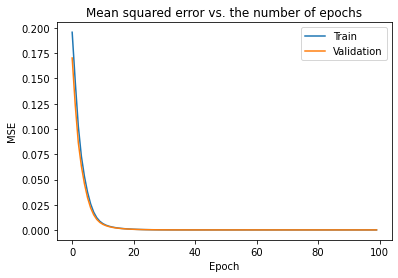

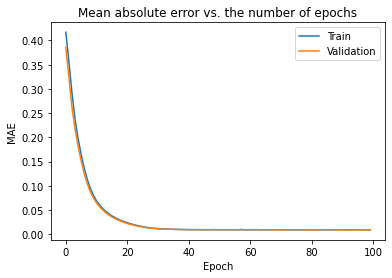

In [96]:
def visualising_data_MSE(hist, name):
#     MSE
    plt.title('Mean squared error vs. the number of epochs')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

def visualising_data_MAE(hist, name):
    plt.title('Mean absolute error vs. the number of epochs')
    plt.plot(hist.history['mean_absolute_error'], label='Train')
    plt.plot(hist.history['val_mean_absolute_error'], label='Validation')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()
    
# data up to the best epoch
# visualising_data_MSE(hypermodel_hist, '/Users/jackkelly/Desktop/Building_Model/Figures/hypermodel_results_MSE.svg')
# data for the full 100 epochs
visualising_data_MSE(history, '/Users/jackkelly/Desktop/Building_Model/Figures/full_epochs_results_MSE.svg')
visualising_data_MAE(history, '/Users/jackkelly/Desktop/Building_Model/Figures/full_epochs_results_MAE.svg')

In [197]:
# shows weights of the ANN
# print(hypermodel.weights)
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 140)               5880      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               14100     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________


In [198]:
# save the tuned model
hypermodel.save('/Users/jackkelly/Desktop/Building_Model/Tuned_40_channels_ANN_model.h5')

# CDF for Tuned Model

In [210]:
def CDF_plot(x, y, name):
    mse_ecdf = plt.plot(x,y, marker='.', linestyle='none', color='blue')
    plt.xlabel('MSE [dB]')
    plt.ylabel('Probability')
    plt.savefig(f'/Users/jackkelly/Desktop/Building_Model/Figures/{name}.svg', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

In [211]:
model1 = keras.models.load_model('/Users/jackkelly/Desktop/Building_Model/Tuned_40_channels_ANN_model.h5')
print(model1.summary())
df = pd.read_csv('/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data_testing.csv')
# dataset
dataset = df.values
# input power and channels statuses
X = dataset[:,0:N_channels+1]
Y = dataset[:,N_channels+1:2*N_channels+1]

xScaler = preprocessing.MinMaxScaler()
yScaler = preprocessing.MinMaxScaler()

xScaler.fit(X)
yScaler.fit(Y)

xTrainNorm = xScaler.transform(X)
yTrainNorm = yScaler.transform(Y)

y_predicted = model1.predict(xTrainNorm)
y_predicted_inverted = yScaler.inverse_transform(y_predicted)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 140)               5880      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               14100     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________
None


90th percentile mse =  0.16002078363722397 dB


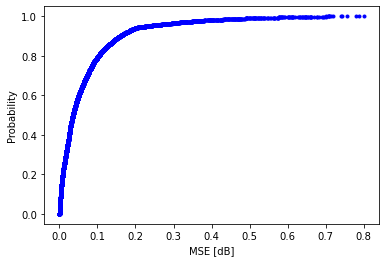

In [215]:
mean_squared_error_store = []
for i in range(10000):
    mean_squared_error_store.append(mean_squared_error(y_predicted_inverted[i], Y[i]))

x_vals = np.sort(mean_squared_error_store)
y_vals = np.arange(1, len(x_vals)+1)/len(x_vals)
# 10000 elements in mseArray so 90th percentile is 9000th element
print('90th percentile mse = ', x_vals[9000],'dB')
x = np.sort(mean_squared_error_store)
y = np.arange(1, len(x)+1)/len(x)
CDF_plot(x, y, 'CDF_tuned_ANN')

# Scatter

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 140)               5880      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               14100     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________
None


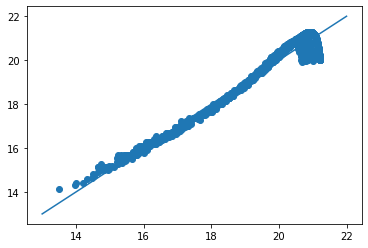

In [238]:
model1 = keras.models.load_model('/Users/jackkelly/Desktop/Building_Model/Tuned_40_channels_ANN_model.h5')
print(model1.summary())
df = pd.read_csv('/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data_testing.csv')
# dataset
dataset = df.values
# input power and channels statuses
X = dataset[:,0:N_channels+1]
Y = dataset[:,N_channels+1:2*N_channels+1]

xScaler = preprocessing.MinMaxScaler()
yScaler = preprocessing.MinMaxScaler()

xScaler.fit(X)
yScaler.fit(Y)

xTrainNorm = xScaler.transform(X)
yTrainNorm = yScaler.transform(Y)

y_predicted = model1.predict(xTrainNorm)
y_predicted_inverted = yScaler.inverse_transform(y_predicted)
scatter_predicted = []
scatter_real = []
# calculate mean GSNRs
for i in range(10000):
    scatter_predicted.append([val for val in (y_predicted_inverted[i]*X[i][1:]) if val != 0][0])
#     scatter_predicted.append(np.mean(y_predicted_inverted[i]*X[i][1:]))
    scatter_real.append([val for val in (Y[i]*X[i][1:]) if val != 0][0])

scatter_predicted, scatter_real = shuffle(scatter_predicted, scatter_real)
    
x = [i for i in range(13,23)]
y = [i for i in range(13,23)]

plt.scatter(scatter_predicted[:1000],scatter_real[:1000])
plt.plot(x,y)

# Bar plot

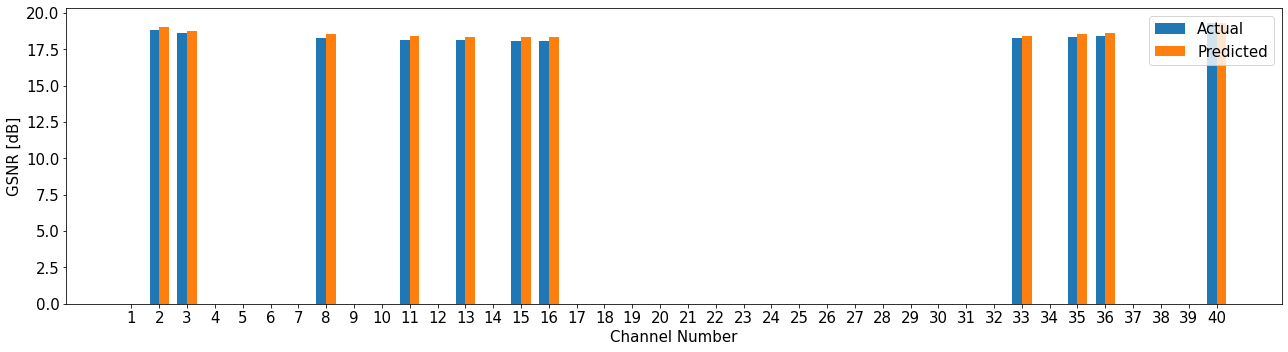

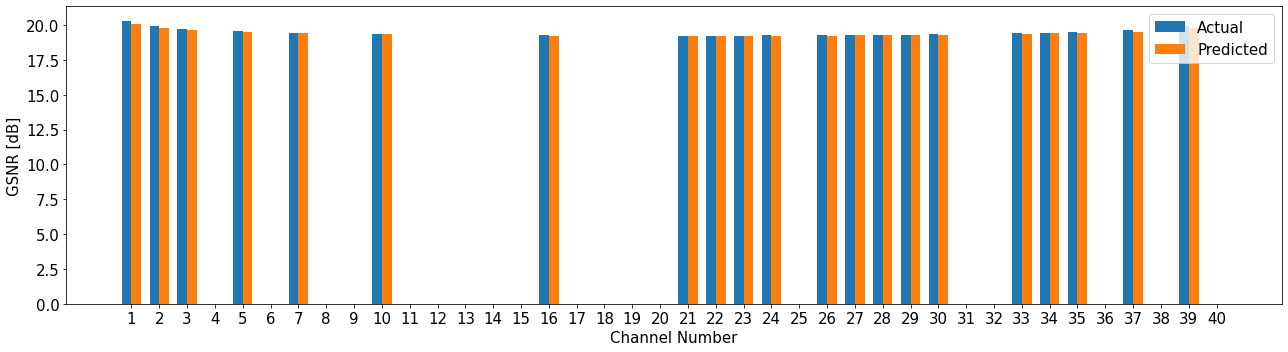

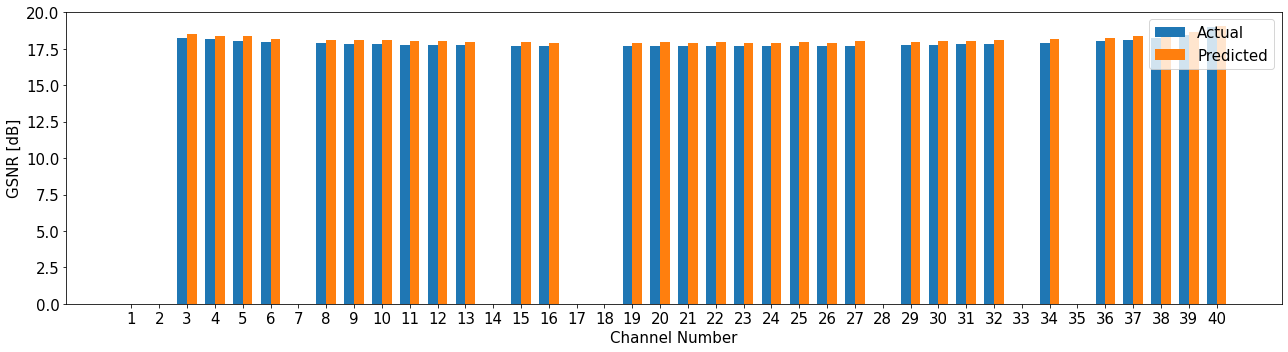

In [332]:
def barplot(index):
    y_actual = Y[index] * X[index][1:]
    y_predicted = y_predicted_inverted[index] * X[index][1:]
    
    labels = [i for i in range(1,41)]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(18,5))
    # plt.figure(figsize=(25,5))
    rects1 = ax.bar(x - width/2, y_actual, width, label='Actual')
    rects2 = ax.bar(x + width/2, y_predicted, width, label='Predicted')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('GSNR [dB]', fontsize=15)
    ax.set_xlabel('Channel Number', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # ax.set_yticklabels(labels, fontsize=12)
    ax.legend(fontsize=15, loc='upper right')

    fig.tight_layout()

    plt.savefig(f'/Users/jackkelly/Desktop/Building_Model/Figures/tuned_channel_bar_chart_{index}.svg', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

barplot(2500)
barplot(5100)
barplot(7500)

# Transfer Learning on different network topologies

In [333]:
def load_TL_model(model_path):
    hypermodel = keras.models.load_model(model_path)
#     hypermodel.summary()
    model = tf.keras.Sequential()
    for layer in hypermodel.layers[:-1]: # go through until last layer
        layer.trainable=False
        model.add(layer)
    model.add(keras.layers.Dense(40, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-06)))
#     model.summary()

    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [334]:
test_data_numbers = [200, 400, 800, 1200, 1600, 2000, 2400]
timings = []
N_channels = 40
def number_of_channels(ending):
    TL_model_results = []
    for i in range(len(test_data_numbers)):
        model = load_TL_model('Tuned_40_channels_ANN_model.h5')
        file_path = (f'/Users/jackkelly/Desktop/Building_Model/Data/{test_data_numbers[i]}_data_points_train_val{ending}.csv')
        X_scale, Y_scale = processing_data(N_channels, file_path)
        file_path = (f'/Users/jackkelly/Desktop/Building_Model/Data/{test_data_numbers[i]}_data_points_test{ending}.csv')
        X_test, Y_test = processing_data(N_channels, file_path)
        print(X_scale.shape, Y_scale.shape, X_test.shape, Y_test.shape)
        start_time = time.time()
        # new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
        new_hist = model.fit(X_scale, Y_scale, validation_split=0.2, epochs=100, shuffle=True, verbose=0)
        training_time = time.time() - start_time
        timings.append(training_time)
        # evaluating transfer-learned model
        eval_result = model.evaluate(X_test, Y_test, verbose=0)[1]
        # evaluating OLD model with new data
        # hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
        TL_model_results.append(eval_result)
    return TL_model_results
TL_model_results_longer = number_of_channels('')
TL_model_results_shorter = number_of_channels('_shorter')
print(TL_model_results_longer)
print(TL_model_results_shorter)

(200, 41) (200, 40) (200, 41) (200, 40)
(400, 41) (400, 40) (400, 41) (400, 40)
(800, 41) (800, 40) (800, 41) (800, 40)
(1200, 41) (1200, 40) (1200, 41) (1200, 40)
(1600, 41) (1600, 40) (1600, 41) (1600, 40)
(2000, 41) (2000, 40) (2000, 41) (2000, 40)
(2400, 41) (2400, 40) (2400, 41) (2400, 40)
(200, 41) (200, 40) (200, 41) (200, 40)
(400, 41) (400, 40) (400, 41) (400, 40)
(800, 41) (800, 40) (800, 41) (800, 40)
(1200, 41) (1200, 40) (1200, 41) (1200, 40)
(1600, 41) (1600, 40) (1600, 41) (1600, 40)
(2000, 41) (2000, 40) (2000, 41) (2000, 40)
(2400, 41) (2400, 40) (2400, 41) (2400, 40)
[0.012447456, 0.0029237024, 0.0011978027, 0.0009425077, 0.000819619, 0.00066937675, 0.0005208822]
[0.013847091, 0.0026674194, 0.0011292879, 0.0008437902, 0.0007012515, 0.00059624395, 0.00045110818]


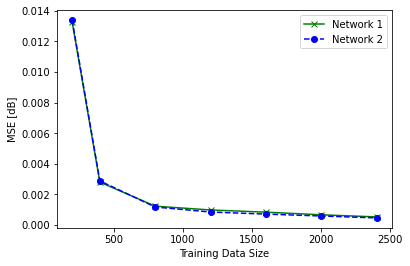

In [241]:
plt.plot(test_data_numbers, TL_model_results_longer, label='Network 1', marker='x', color='g')
plt.plot(test_data_numbers, TL_model_results_shorter, label='Network 2', marker='o', color='b', linestyle='--')
plt.ylabel('MSE [dB]')
plt.xlabel('Training Data Size')
plt.legend()
plt.savefig('/Users/jackkelly/Desktop/Building_Model/Figures/transfer_learning_results.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

# Transfer learning on Raman networks

In [91]:
### Import all the different datasets
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/Raman_data.csv'
df = pd.read_csv(file_path)
dataset = pd.DataFrame(df)
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/Raman_data2.csv'
df2 = pd.read_csv(file_path)
dataset2 = pd.DataFrame(df2)
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/Raman_data3.csv'
df3 = pd.read_csv(file_path)
dataset3 = pd.DataFrame(df3)
df_tot = pd.concat([dataset, dataset2, dataset3],ignore_index=True)
dataset4 = df_tot.values
X = dataset4[:,0:N_channels+1]
# channel SNRs
Y = dataset4[:,N_channels+1:2*N_channels+1]
X, Y = shuffle(X, Y)
# scaling between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
Y = min_max_scaler.fit_transform(Y)

In [92]:
model = load_TL_model('Tuned_40_channels_ANN_model.h5')
start_time = time.time()
raman_hist = model.fit(X, Y, validation_split=0.2, epochs=200, shuffle=True, verbose=2)
training_time = time.time() - start_time
print(training_time)

Train on 160 samples, validate on 40 samples
Epoch 1/200
160/160 - 1s - loss: 0.3067 - mean_squared_error: 0.3062 - val_loss: 0.2864 - val_mean_squared_error: 0.2860
Epoch 2/200
160/160 - 0s - loss: 0.2851 - mean_squared_error: 0.2846 - val_loss: 0.2713 - val_mean_squared_error: 0.2708
Epoch 3/200
160/160 - 0s - loss: 0.2651 - mean_squared_error: 0.2646 - val_loss: 0.2568 - val_mean_squared_error: 0.2563
Epoch 4/200
160/160 - 0s - loss: 0.2462 - mean_squared_error: 0.2458 - val_loss: 0.2432 - val_mean_squared_error: 0.2428
Epoch 5/200
160/160 - 0s - loss: 0.2284 - mean_squared_error: 0.2280 - val_loss: 0.2306 - val_mean_squared_error: 0.2302
Epoch 6/200
160/160 - 0s - loss: 0.2122 - mean_squared_error: 0.2117 - val_loss: 0.2192 - val_mean_squared_error: 0.2187
Epoch 7/200
160/160 - 0s - loss: 0.1980 - mean_squared_error: 0.1975 - val_loss: 0.2087 - val_mean_squared_error: 0.2083
Epoch 8/200
160/160 - 0s - loss: 0.1854 - mean_squared_error: 0.1850 - val_loss: 0.1994 - val_mean_squared_e

Epoch 68/200
160/160 - 0s - loss: 0.0154 - mean_squared_error: 0.0149 - val_loss: 0.0308 - val_mean_squared_error: 0.0303
Epoch 69/200
160/160 - 0s - loss: 0.0150 - mean_squared_error: 0.0145 - val_loss: 0.0302 - val_mean_squared_error: 0.0297
Epoch 70/200
160/160 - 0s - loss: 0.0146 - mean_squared_error: 0.0141 - val_loss: 0.0295 - val_mean_squared_error: 0.0291
Epoch 71/200
160/160 - 0s - loss: 0.0142 - mean_squared_error: 0.0138 - val_loss: 0.0289 - val_mean_squared_error: 0.0285
Epoch 72/200
160/160 - 0s - loss: 0.0139 - mean_squared_error: 0.0134 - val_loss: 0.0283 - val_mean_squared_error: 0.0279
Epoch 73/200
160/160 - 0s - loss: 0.0136 - mean_squared_error: 0.0131 - val_loss: 0.0278 - val_mean_squared_error: 0.0273
Epoch 74/200
160/160 - 0s - loss: 0.0133 - mean_squared_error: 0.0128 - val_loss: 0.0272 - val_mean_squared_error: 0.0268
Epoch 75/200
160/160 - 0s - loss: 0.0130 - mean_squared_error: 0.0125 - val_loss: 0.0267 - val_mean_squared_error: 0.0262
Epoch 76/200
160/160 - 0

Epoch 135/200
160/160 - 0s - loss: 0.0058 - mean_squared_error: 0.0053 - val_loss: 0.0123 - val_mean_squared_error: 0.0118
Epoch 136/200
160/160 - 0s - loss: 0.0058 - mean_squared_error: 0.0053 - val_loss: 0.0121 - val_mean_squared_error: 0.0116
Epoch 137/200
160/160 - 0s - loss: 0.0058 - mean_squared_error: 0.0052 - val_loss: 0.0120 - val_mean_squared_error: 0.0115
Epoch 138/200
160/160 - 0s - loss: 0.0057 - mean_squared_error: 0.0052 - val_loss: 0.0119 - val_mean_squared_error: 0.0114
Epoch 139/200
160/160 - 0s - loss: 0.0057 - mean_squared_error: 0.0052 - val_loss: 0.0118 - val_mean_squared_error: 0.0113
Epoch 140/200
160/160 - 0s - loss: 0.0056 - mean_squared_error: 0.0051 - val_loss: 0.0117 - val_mean_squared_error: 0.0112
Epoch 141/200
160/160 - 0s - loss: 0.0056 - mean_squared_error: 0.0051 - val_loss: 0.0116 - val_mean_squared_error: 0.0111
Epoch 142/200
160/160 - 0s - loss: 0.0055 - mean_squared_error: 0.0050 - val_loss: 0.0115 - val_mean_squared_error: 0.0110
Epoch 143/200
16

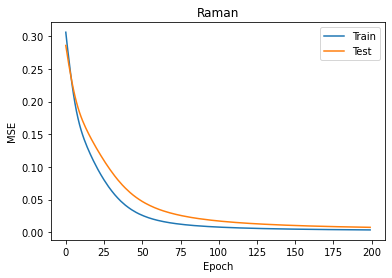

In [93]:
plt.title('Raman')
plt.plot(raman_hist.history['mean_squared_error'], label='Train')
plt.plot(raman_hist.history['val_mean_squared_error'], label='Test')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()